# Setup

In [1]:
# Install packages
!pip install xmltodict

# Import required packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import glob
import imageio
import cv2
import argparse
import imutils
import json
import xmltodict
import pprint
import json
import ast
import pandas as pd
import seaborn as sns
from PIL import Image 
import PIL 
from typing import Tuple
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.colab.patches import cv2_imshow   # needed for colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [3]:
IMAGE_PATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/01_PHASE1_VOC/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/'
LABEL_PATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/01_PHASE1_VOC/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/Annotations/'

# Extract Labels from Annotations

In [4]:
# list out the image files
image_files = os.listdir(IMAGE_PATH)
print(len(image_files))
image_files[:5]

17125


['2012_003185.jpg',
 '2012_001577.jpg',
 '2012_002639.jpg',
 '2012_002992.jpg',
 '2012_003686.jpg']

In [5]:
# list out the annotation files
annotation_files = os.listdir(LABEL_PATH)
print(len(annotation_files))
annotation_files[:5]

17125


['2009_004247.xml',
 '2009_004248.xml',
 '2009_004249.xml',
 '2009_004255.xml',
 '2009_004258.xml']

# Feature Vector Functions

In [4]:
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int] = (128,128), 
                    padding_color: Tuple[int] = (255, 255, 255)) -> np.array:
    """
    https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
    Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image


def get_hog_feature_vector(image, blur_value=5, orientations=9, pixels_per_cell=16, cells_per_block=2):
    
    # blur image first to remove some noise
    image_blurred = cv2.GaussianBlur(image, (blur_value, blur_value), 0) 

    hog_feature_vector, hog_image = hog(image_blurred, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                        cells_per_block=(cells_per_block, cells_per_block), visualize=True, channel_axis=-1)

    return hog_feature_vector


def display_hog_feature_vector(image, blur_value=5, orientations=9, pixels_per_cell=16, cells_per_block=2):
    
    # blur image first to remove some noise
    image_blurred = cv2.GaussianBlur(image, (blur_value, blur_value), 0) 

    hog_feature_vector, hog_image = hog(image_blurred, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                        cells_per_block=(cells_per_block, cells_per_block), visualize=True, channel_axis=-1)

    fig, ax = plt.subplots()

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax.axis('off')
    ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax.set_title('Histogram of Oriented Gradients')
    plt.plot(hog_image_rescaled, cmap=plt.cm.gray)
    plt.show()


def get_hsv_feature_vector(image, bins=32):

    # cv2.calcHist([images], [channels], [mask], [bins], [hist_range])

    # do not use a padded or resized image
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # get the color histograms
    hue = cv2.calcHist([hsv_image], [2], None, [bins], [0, 256])
    sat = cv2.calcHist([hsv_image], [1], None, [bins], [0, 256])
    val = cv2.calcHist([hsv_image], [0], None, [bins], [0, 256])
    
    # combine the information into one vector
    hsv_feature_vector = np.concatenate([hue, sat, val], axis=0)
    hsv_feature_vector = hsv_feature_vector.reshape(-1)

    return hsv_feature_vector


def display_hsv_histogram(image):
    
    H, S, V = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2HSV))
    image = cv2.cvtColor(cv2.merge([H, S, V]), cv2.COLOR_HSV2RGB)

    h, s, v = image[:, : ,0], image[:, :, 1], image[:, :, 2]
    hist_h = cv2.calcHist([h],[0],None,[256],[0,256])
    hist_s = cv2.calcHist([s],[0],None,[256],[0,256])
    hist_v = cv2.calcHist([v],[0],None,[256],[0,256])
    plt.plot(hist_h, color='r', label='h')
    plt.plot(hist_s, color='g', label='s')
    plt.plot(hist_v, color='b', label='v')
    plt.legend()
    plt.figure(figsize=(12,6))
    plt.show()


def get_sift_feature_vector(image, max_keypoints=20):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blur image to remove noise
    image_blurred = cv2.GaussianBlur(gray_image, (3,3), 0) 

    # keypoints
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=max_keypoints)
    keypoints, descriptors = sift.detectAndCompute(image_blurred, None)

    return keypoints, descriptors


def display_sift_features(image, max_keypoints=50):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blur image to remove noise
    image_blurred = cv2.GaussianBlur(gray_image, (5,5), 0) 

    #keypoints
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=max_keypoints)
    keypoints, descriptors = sift.detectAndCompute(image_blurred, None)

    img_sift = cv2.drawKeypoints(gray_image, keypoints, image)
    plt.imshow(img_sift)


def flatten_sift_descriptors(sift_descriptor):

    flattened_sift_descriptor = sift_descriptor.flatten()
    
    return flattened_sift_descriptor

# Preprocessing Functions

In [5]:
def get_unpadded_image_data(image_file_path):
    
    image_unpadded = plt.imread(image_file_path)

    return image_unpadded


def get_padded_image_data(image_unpadded, pad_size=128):
    
    image_padded = resize_with_pad(image_unpadded, (pad_size, pad_size))
    
    return image_padded

In [6]:
def get_name_and_label_from_xml(file_path, filename):

    '''
    Retrieve the image name and label from .xml annotation
    Returns two objects
    1. image name
    2. image label
    '''

    with open(file_path + '/' + filename) as xml_file:

        # convert xml file to dictionary, then read it as a json object
        data_dict = xmltodict.parse(xml_file.read())
        json_data = json.loads(json.dumps(data_dict))
        
        # image filename
        name = json_data['annotation']['filename'].split('.')[0]

        # some labels are nested more than others
        try:
            label = json_data['annotation']['object']['name']
        except TypeError:
            label = json_data['annotation']['object'][0]['name']

    return name, label

In [7]:
def get_image_data_from_xml(path, filename):
    '''
    the annoations contain important information regarding the
    classified label objects in each image along with their bounding boxes

    each image can have more than one object

    this function returns a single nested dictionary where 
    a. the top level key is the image file
    b. nested keys are each object and their bounding box
    '''

    with open(path + filename) as xml_file:

        # convert xml file to dictionary, then read it as a json object
        data_dict = xmltodict.parse(xml_file.read())
        json_data = json.loads(json.dumps(data_dict))
        
        # image filename
        image_filename = json_data['annotation']['filename']

        # dictionary to hold information for all objects
        objects_in_image_dict = {}

        # dictionary for each object label and its bounding box
        object_info_dict = {}

        # get object information
        image_objects = json_data['annotation']['object']

        # if there is only one object, the info will just be in a dictionary (no list)
        
        if type(image_objects) == dict:
            obj_label = image_objects['name']
            obj_bounding_box = image_objects['bndbox']
            object_info_dict[obj_label] = obj_bounding_box
        
        # otherwise there is more than one object, the info will be in a list of dictionaries
        else:
            for obj in image_objects:
                obj_label = obj['name']
                obj_bounding_box = obj['bndbox']
                object_info_dict[obj_label] = obj_bounding_box

        objects_in_image_dict[image_filename] = object_info_dict

        return objects_in_image_dict

In [8]:
def crop_objects_from_image(input_filepath, filename, object_dict, output_filepath):
    '''
    this function uses the bounding boxes provided in the object_dict
    to crop objects from the input file and saves the unpadded version to the output_filepath

    this function does not return any information
    '''

    image = plt.imread(input_filepath + filename)

    # retrieve bounding boxes
    image_objects = list(object_dict[filename].keys())

    for obj in image_objects:

        # crop based on bounding box
        X = int(float(object_dict[filename][obj]['xmin']))
        Y = int(float(object_dict[filename][obj]['ymin']))
        W = int(float(object_dict[filename][obj]['xmax']))
        H = int(float(object_dict[filename][obj]['ymax']))

        cropped_image = image[Y:Y+H, X:X+W]
        
        # save cropped object
        im = Image.fromarray(cropped_image)
        im.save(output_filepath + filename.split('.')[0] + '_' + obj + '.jpg')

    return

In [9]:
def get_label_from_cropped_filename(filename):

    label = filename.split('.')[0].split('_')[-1]

    return label

# Function Testing

## motorbike 128

(128, 128, 3)


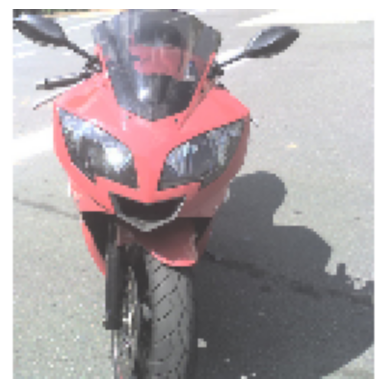

In [ ]:
image_padded_128 = resize_with_pad(cropped_image, (128, 128))
plt.axis('off')
plt.imshow(image_padded_128)
print(image_padded_128.shape)

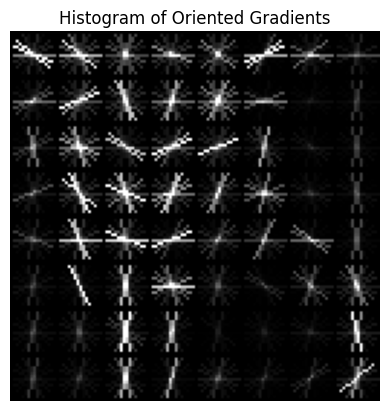

In [ ]:
display_hog_feature_vector(image_padded_128)

In [ ]:
get_hog_feature_vector(image_padded_128, 5, 9, 4, 2)

array([0.20003623, 0.        , 0.12490373, ..., 0.        , 0.34589391,
       0.36224928])

In [ ]:
# HOG feature vector with resized size image

hog_feature_vector = get_hog_feature_vector(image_padded_128)
print(f'HOG feature vector of length {len(hog_feature_vector)}: ', hog_feature_vector)

HOG feature vector of length 1764:  [0.08310665 0.02177855 0.0672388  ... 0.03711239 0.05516818 0.33090429]


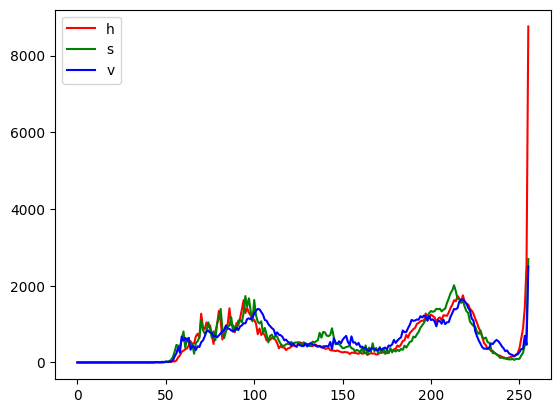

<Figure size 1200x600 with 0 Axes>

In [ ]:
display_hsv_histogram(cropped_image)

In [ ]:
'''
Indices
Hue: 0-31
Saturation: 32-63
Value: 64-95
'''

get_hsv_feature_vector(image_unpadded)

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
       1.8000e+01, 6.7000e+01, 1.8510e+03, 4.3830e+03, 5.9540e+03,
       6.7830e+03, 7.7620e+03, 1.0184e+04, 8.8460e+03, 6.0180e+03,
       4.0180e+03, 4.2020e+03, 3.4020e+03, 2.7970e+03, 2.5630e+03,
       2.3520e+03, 2.3260e+03, 3.1290e+03, 6.5750e+03, 1.2857e+04,
       1.6982e+04, 1.7651e+04, 2.0123e+04, 1.0785e+04, 6.6830e+03,
       6.7350e+03, 2.4949e+04, 7.3280e+04, 6.3151e+04, 2.5752e+04,
       9.5490e+03, 5.4620e+03, 2.9910e+03, 2.3330e+03, 2.0740e+03,
       1.7840e+03, 1.6850e+03, 2.0330e+03, 1.5920e+03, 1.7090e+03,
       2.7510e+03, 2.9440e+03, 7.3600e+02, 1.3500e+02, 3.1000e+01,
       4.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3741e+04,
       2.2190e+03, 3.4270e+03, 7.9970e+03, 6.6380e+03, 6.1270e+03,
       7.3630e+03, 2.5640e+03, 4.1500e+03, 5.3700e+03, 4.8410e

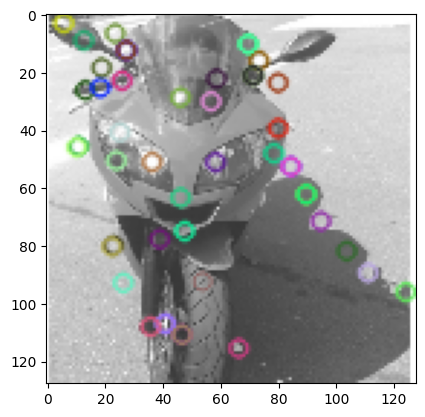

In [ ]:
display_sift_features(image_padded_128)

In [ ]:
'''
Each ***keypoint*** has a location, scale, orientation. 
Each ***descriptor*** stores the local image region about each keypoint 
  that is distinct and invariant to variations such as changes in viewpoint and illumination
'''

keypoints, descriptors = get_sift_feature_vector(image_padded_128)
print('keypoints: ', keypoints[:3])
print('descriptors: ', descriptors[:3])
print('number of features: ', len(flatten_sift_descriptors(descriptors)))

keypoints:  (< cv2.KeyPoint 0x7f74bf31f780>, < cv2.KeyPoint 0x7f745dc401e0>, < cv2.KeyPoint 0x7f745dd6e480>)
descriptors:  [[ 26.  73.  10.   6.   3.   1.   4.  10.  32. 131.  81.  48.   9.  10.
   26.  18.   0.   2.  29. 133.  47.  27.  35.   7.   0.   1.  23.  29.
    4.   8.  46.  20.  22.  17.  10.  21.  51.   9.   4.   4. 133.  41.
   25.   9.   1.   7.  47.  91.  15.   1.   6.  17.   8.  69. 133.  44.
    0.   0.   2.  17.  17.  30. 133.  42.  25.   1.   0.   3.  63.  23.
   35.  16. 133.  24.   0.   0.   1.  10.  17.  35.  86.   8.   0.   9.
   52.  60.  40.  15.   0.   0.  14.  95.  86.  43.  21.   2.  14.   0.
    0.   2.  27.  36.  30.  53. 133.   6.   0.   0.   3.  32.  15.  29.
  102.   4.   0.   2.  46.  26.   0.   7.   0.   0.   0.   8. 133.  50.
    0.   0.]
 [  0.   0.   2. 108.  85.   0.   0.   0.   3.   3.  27.  85.  32.   5.
    2.   3.   0.   0.   5.  46.  21.  17.   4.   1.   0.   0.   0.   0.
    0.   0.   0.   0.  14.   6.  10. 143. 143.   0.   0.   1. 137.  23.


## motorbike 640

(640, 640, 3)


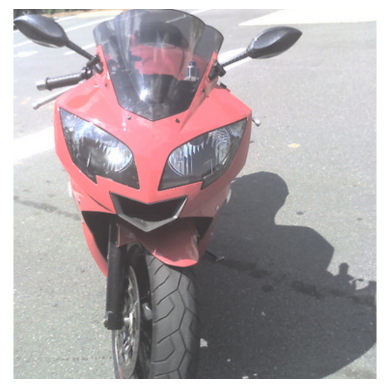

In [ ]:
image_padded_640 = resize_with_pad(cropped_image, (640, 640))
plt.axis('off')
plt.imshow(image_padded_640)
print(image_padded_640.shape)

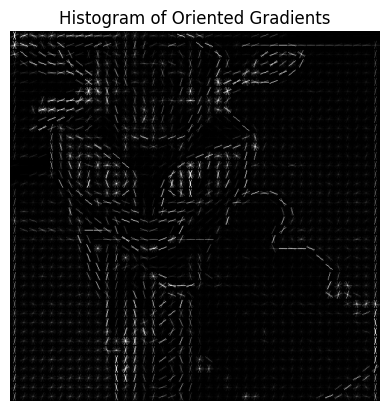

In [ ]:
display_hog_feature_vector(image_padded_640)

In [ ]:
get_hog_feature_vector(image_padded_640, 5, 9, 4, 2)

array([0.08114314, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [ ]:
# HOG feature vector with resized size image

hog_feature_vector = get_hog_feature_vector(image_padded_640)
print(f'HOG feature vector of length {len(hog_feature_vector)}: ', hog_feature_vector)

HOG feature vector of length 54756:  [0.29782527 0.01251049 0.08641456 ... 0.1136894  0.16101856 0.35438881]


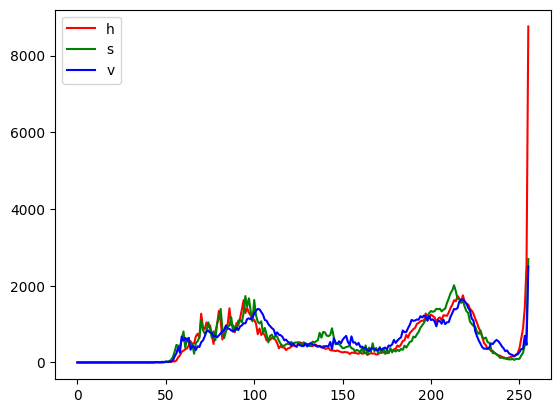

<Figure size 1200x600 with 0 Axes>

In [ ]:
display_hsv_histogram(cropped_image)

In [ ]:
'''
Indices
Hue: 0-31
Saturation: 32-63
Value: 64-95
'''

get_hsv_feature_vector(image_unpadded)

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
       1.8000e+01, 6.7000e+01, 1.8510e+03, 4.3830e+03, 5.9540e+03,
       6.7830e+03, 7.7620e+03, 1.0184e+04, 8.8460e+03, 6.0180e+03,
       4.0180e+03, 4.2020e+03, 3.4020e+03, 2.7970e+03, 2.5630e+03,
       2.3520e+03, 2.3260e+03, 3.1290e+03, 6.5750e+03, 1.2857e+04,
       1.6982e+04, 1.7651e+04, 2.0123e+04, 1.0785e+04, 6.6830e+03,
       6.7350e+03, 2.4949e+04, 7.3280e+04, 6.3151e+04, 2.5752e+04,
       9.5490e+03, 5.4620e+03, 2.9910e+03, 2.3330e+03, 2.0740e+03,
       1.7840e+03, 1.6850e+03, 2.0330e+03, 1.5920e+03, 1.7090e+03,
       2.7510e+03, 2.9440e+03, 7.3600e+02, 1.3500e+02, 3.1000e+01,
       4.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3741e+04,
       2.2190e+03, 3.4270e+03, 7.9970e+03, 6.6380e+03, 6.1270e+03,
       7.3630e+03, 2.5640e+03, 4.1500e+03, 5.3700e+03, 4.8410e

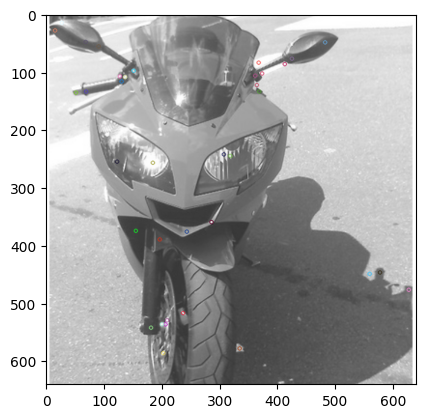

In [ ]:
display_sift_features(image_padded_640)

In [ ]:
'''
Each ***keypoint*** has a location, scale, orientation. 
Each ***descriptor*** stores the local image region about each keypoint 
  that is distinct and invariant to variations such as changes in viewpoint and illumination
'''

keypoints, descriptors = get_sift_feature_vector(image_padded_640)
print('keypoints: ', keypoints[:3])
print('descriptors: ', descriptors[:3])
print('number of features: ', len(flatten_sift_descriptors(descriptors)))

keypoints:  (< cv2.KeyPoint 0x7f74bf308ea0>, < cv2.KeyPoint 0x7f74bf3083c0>, < cv2.KeyPoint 0x7f745dbf5ba0>)
descriptors:  [[  1.   1.   1.  10.  65. 120.  75.  11.   0.   0.   0.   2.  50.  55.
   27.  20.   1.   0.   0.   0.   2.  11.  76.  26.   2.   0.   0.   0.
    1.   3.  35. 120.  11.  14.  57. 120.  78.  20.   4.   4.  70.   8.
    5.  32.  47.  15.  67. 120.   9.   3.   3.   1.   1.  27. 120.  81.
    4.   0.   0.   0.   0.   2.  96. 120.  30.  16.  29.  62.  16.   8.
   13.  19. 120.  72.  11.   7.   1.   1.  14.  63.  57.  54.  27.   3.
    2.  10.  26.  57.  24.   1.   0.   0.   0.   1.  25.  73.  33.   6.
    0.   0.   1.   3.  52. 116.  19.   7.   0.   0.   0.   0. 120. 117.
   26.   7.   1.   0.   0.   0.  24. 120.   9.   0.   0.   0.   0.   0.
    2.  43.]
 [  6.  38.  19.   0.   0.   0.   6.  17.  22.  24.   4.   0.   0.   0.
   16.  40.   9.   1.   0.   0.   0.  15.  94.  57.   0.   0.   0.   0.
    0.  45. 123.   2.  36.  78.  36.   2.   0.   0.   0.   4. 123.  50.


# Test Feature Vectors

## Test Image

(640, 640, 3)


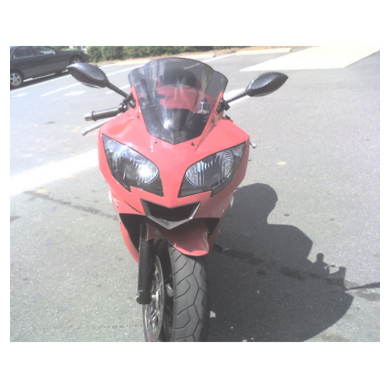

In [ ]:
# load test image

image_file_path = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/01_PHASE1_VOC/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/2009_004249.jpg'

try:
    image_unpadded = plt.imread(image_file_path)
    image_padded = resize_with_pad(image_unpadded, (640, 640))
    plt.axis('off')
    plt.imshow(image_padded)
    print(image_padded.shape)
except FileNotFoundError:
    print('image not found')

## HOG Feature Vector

In [ ]:
# use this set of parameters (pixels per cell = 4) for accuracy optimization
get_hog_feature_vector(image_padded, 5, 9, 4, 2)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# use this set of parameters (pixels per cell = 24) for efficiency optimization
get_hog_feature_vector(image_padded, 5, 9, 24, 2)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# HOG feature vector with resized size image

hog_feature_vector = get_hog_feature_vector(image_padded)
print(f'HOG feature vector of length {len(hog_feature_vector)}: ', hog_feature_vector)

HOG feature vector of length 54756:  [0. 0. 0. ... 0. 0. 0.]


## HSV Feature Vector

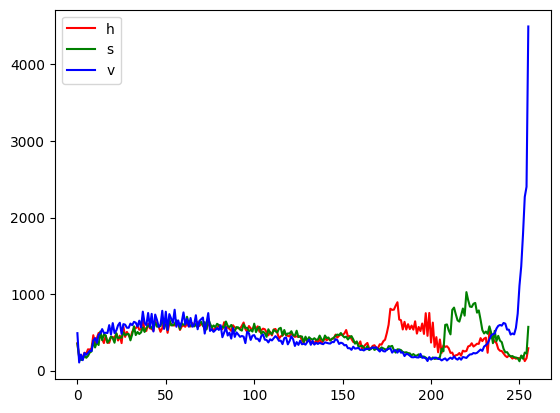

<Figure size 1200x600 with 0 Axes>

In [ ]:
display_hsv_histogram(image_unpadded)

In [ ]:
'''
Indices
Hue: 0-31
Saturation: 32-63
Value: 64-95
'''

get_hsv_feature_vector(image_unpadded)

array([1.0940e+03, 2.6960e+03, 3.3150e+03, 3.4760e+03, 3.8420e+03,
       3.9270e+03, 4.3090e+03, 4.6560e+03, 4.8820e+03, 4.6210e+03,
       4.5230e+03, 4.2760e+03, 4.0120e+03, 3.7280e+03, 3.4760e+03,
       3.2580e+03, 2.9690e+03, 2.9120e+03, 3.2090e+03, 3.2130e+03,
       2.8720e+03, 2.7560e+03, 2.6570e+03, 2.1230e+03, 1.8060e+03,
       1.6480e+03, 1.5430e+03, 1.6320e+03, 2.2340e+03, 3.9700e+03,
       4.3820e+03, 1.4983e+04, 1.1516e+04, 1.6436e+04, 1.0918e+04,
       9.7330e+03, 8.6110e+03, 8.3030e+03, 8.9490e+03, 8.5510e+03,
       7.5140e+03, 6.4730e+03, 3.2060e+03, 2.6660e+03, 2.4580e+03,
       2.0550e+03, 1.8510e+03, 1.4070e+03, 1.1540e+03, 6.5900e+02,
       4.4000e+02, 3.6000e+02, 2.0800e+02, 2.2700e+02, 1.5400e+02,
       1.5200e+02, 6.5000e+01, 7.9000e+01, 6.8000e+01, 6.4000e+01,
       3.4000e+01, 2.2000e+01, 1.1000e+01, 6.5600e+02, 6.5220e+03,
       9.7160e+03, 1.2390e+04, 1.0593e+04, 7.6230e+03, 3.0960e+03,
       2.2140e+03, 6.1600e+02, 1.1470e+03, 2.0170e+03, 1.9260e

## SIFT Feature Vector

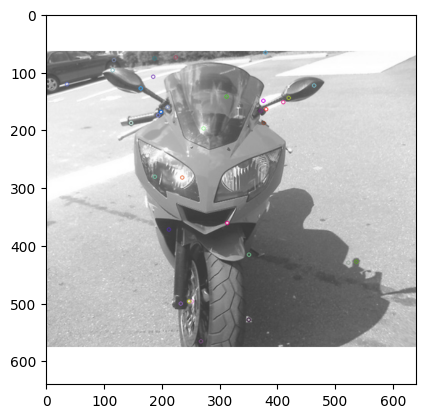

In [ ]:
display_sift_features(image_padded)

In [ ]:
'''
Each ***keypoint*** has a location, scale, orientation. 
Each ***descriptor*** stores the local image region about each keypoint 
  that is distinct and invariant to variations such as changes in viewpoint and illumination
'''

keypoints, descriptors = get_sift_feature_vector(image_padded)
print('keypoints: ', keypoints[:3])
print('descriptors: ', descriptors[:3])
print('number of features: ', len(flatten_sift_descriptors(descriptors)))

keypoints:  (< cv2.KeyPoint 0x7fde55604510>, < cv2.KeyPoint 0x7fde504e5f60>, < cv2.KeyPoint 0x7fde504e5f00>)
descriptors:  [[  1.   0.   0.  22.  98.   5.   8.  14. 122.   2.   0.   1.   4.   1.
   10.  84. 170.   6.   0.   0.   0.   0.   0. 100.  49.   2.   1.   8.
   33.   2.   2.  24.  10.   0.   0.   9.  67.  10.   8.  21. 118.  33.
    1.   1.   1.   4.  12.  42. 170.  91.   0.   0.   0.   0.   0.  30.
   59.  13.   2.  17.  63.   9.   0.   7.  28.   3.   1.  10.  38.   8.
    2.  13. 115.  10.   8.   3.   0.  10.  15.  44. 170.  21.   2.   0.
    0.   1.   1.  94.  51.  13.  17.  14.  18.  18.   1.   7.   8.   5.
    4.   9.  26.   6.   1.   3. 138.  11.  16.   8.   1.   1.   1.  44.
  170.  30.   6.   1.   0.   0.   0.  41.  10.  15.  29.  47.   6.   0.
    0.   0.]
 [ 42.   9.   1.  24.  30.   0.   0.   2. 138.   4.   1.  21.  11.   0.
    0.  38. 113.   1.   1.  12.  64.   3.   1.  33.   0.   0.   0.  30.
  138.   4.   0.   0.  53.   5.   2.  29.  39.   0.   0.   3. 138.  13.


# Crop Objects from Images

In [109]:
# output_path = '/content/'

output_path = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/ALL_IMAGES_CROPPED/'

# get all objects from the images
for image in annotation_files:    
    image_data = get_image_data_from_xml(LABEL_PATH, image)
    filename = list(image_data.keys())[0]
    crop_objects_from_image(IMAGE_PATH, filename, image_data, output_path)

# Assign Labels to Images

In [415]:
# filepath = '/content/'
filepath = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/ALL_IMAGES_CROPPED/'

# list out the image files
cropped_filenames = os.listdir(filepath)

filenames = []

for file in os.listdir(filepath):
    if file.endswith('.jpg'):
        filenames.append(file)

print(len(filenames))
filenames[:5]

23739
23738


['2009_000615_person.jpg',
 '2009_000615_sofa.jpg',
 '2009_000617_person.jpg',
 '2009_000614_cat.jpg',
 '2009_000611_motorbike.jpg']

In [416]:
def get_label_from_cropped_filename(filename):

    label = filename.split('.')[0].split('_')[-1]

    return label

In [417]:
# add filenames to a dataframe
image_df = pd.DataFrame({'filename':filenames})

# get full filepath
image_df['filepath'] = filepath + image_df['filename']

# get label
image_df['label'] = image_df.apply(lambda x: get_label_from_cropped_filename(x['filename']), axis=1)

image_df.head()

filename  \
0     2009_000615_person.jpg   
1       2009_000615_sofa.jpg   
2     2009_000617_person.jpg   
3        2009_000614_cat.jpg   
4  2009_000611_motorbike.jpg   

                                            filepath      label  
0  /content/drive/MyDrive/DATASCI281_FinalProject...     person  
1  /content/drive/MyDrive/DATASCI281_FinalProject...       sofa  
2  /content/drive/MyDrive/DATASCI281_FinalProject...     person  
3  /content/drive/MyDrive/DATASCI281_FinalProject...        cat  
4  /content/drive/MyDrive/DATASCI281_FinalProject...  motorbike

# Split into Train/Test

In [419]:
# train / val / test split
#    70 / 10  / 20 

train_pct = int(0.7 * len(image_df))
val_pct = int(0.8 * len(image_df))

# the split is done using a numpy solution
# first shuffle all of the samples at a random state
# then split into the percentages above
train_df, val_df, test_df = np.split(image_df.sample(frac=1, random_state=281), [train_pct, val_pct])

print(len(train_df))
print(len(val_df))
print(len(test_df))

# export splits

# train split
train_df.to_csv('/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/train_images_with_labels.csv')

# val split
val_df.to_csv('/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/val_images_with_labels.csv')

# test split
test_df.to_csv('/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/test_images_with_labels.csv')

16616
2374
4748


In [420]:
# check number of labeled classes in *TRAIN SUBSET* PASCAL VOC dataset
print(train_df['label'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

person         40.2%
chair           5.8%
dog             5.7%
car             5.4%
cat             4.8%
bird            3.5%
bottle          3.5%
sofa            3.3%
aeroplane       3.0%
diningtable     2.9%
tvmonitor       2.6%
pottedplant     2.6%
train           2.5%
bicycle         2.5%
motorbike       2.4%
boat            2.3%
horse           2.2%
bus             1.9%
sheep           1.6%
cow             1.3%
Name: label, dtype: object


In [421]:
# check number of labeled classes in *VAL SUBSET* PASCAL VOC dataset
print(val_df['label'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

person         41.0%
chair           6.3%
car             5.5%
dog             5.1%
cat             4.7%
tvmonitor       3.5%
diningtable     3.0%
bird            2.9%
bottle          2.9%
sofa            2.9%
bicycle         2.7%
pottedplant     2.7%
boat            2.5%
aeroplane       2.5%
horse           2.4%
motorbike       2.4%
train           2.1%
cow             1.9%
bus             1.8%
sheep           1.0%
Name: label, dtype: object


In [422]:
# check number of labeled classes in *TEST SUBSET* PASCAL VOC dataset
print(test_df['label'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

person         40.6%
dog             5.7%
car             5.5%
chair           5.4%
cat             4.7%
bottle          3.5%
bird            3.5%
aeroplane       3.2%
diningtable     2.8%
pottedplant     2.7%
tvmonitor       2.7%
bicycle         2.7%
sofa            2.6%
motorbike       2.6%
train           2.5%
boat            2.4%
bus             2.2%
horse           2.0%
cow             1.5%
sheep           1.3%
Name: label, dtype: object


## Train

In [88]:
# append the image data now to the train subset
train_df['image_data_unpadded'] = train_df.apply(lambda x: get_unpadded_image_data(x['filepath']), axis=1)

train_df['image_data_padded'] = train_df.apply(lambda x: get_padded_image_data(x['image_data_unpadded'], 128), axis=1)
train_df.head()

filename  \
0     2008_003463_person.jpg   
1  2009_003705_aeroplane.jpg   
2     2011_002063_person.jpg   
3     2008_002813_person.jpg   
4     2010_006952_person.jpg   

                                            filepath      label  \
0  /content/drive/MyDrive/DATASCI281_FinalProject...     person   
1  /content/drive/MyDrive/DATASCI281_FinalProject...  aeroplane   
2  /content/drive/MyDrive/DATASCI281_FinalProject...     person   
3  /content/drive/MyDrive/DATASCI281_FinalProject...     person   
4  /content/drive/MyDrive/DATASCI281_FinalProject...     person   

                                 image_data_unpadded  \
0  [[[133, 125, 114], [133, 125, 114], [135, 127,...   
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
2  [[[3, 3, 1], [3, 3, 1], [3, 3, 1], [3, 3, 1], ...   
3  [[[107, 105, 118], [96, 98, 110], [113, 121, 1...   
4  [[[52, 71, 88], [65, 84, 101], [69, 87, 107], ...   

                                   image_data_padded  \
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
3  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...   

                                          hog_vector  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.22904671548739214, 0.00015867583778304795, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [89]:
# HOG
train_df['hog_vector'] = train_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded']), axis=1)

# create hog vector df
hog_train_unsplit_df = train_df[['label','hog_vector']]
hog_train_unsplit_df.head()

num_hog_features = len(hog_train_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = train_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_train_temp_df = pd.DataFrame(hog_train_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_train_df = hog_train_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_train_df.to_csv('/content/final_train_hog_vectors.csv')

hog_train_df.head()

hog_1     hog_2    hog_3    hog_4     hog_5     hog_6     hog_7  hog_8  \
0  0.000000  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000    0.0   
1  0.000000  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000    0.0   
2  0.356393  0.000455  0.00259  0.00091  0.004681  0.001365  0.000576    0.0   
3  0.000000  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000    0.0   
4  0.000000  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000    0.0   

      hog_9    hog_10  ...  hog_1756  hog_1757  hog_1758  hog_1759  hog_1760  \
0  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.356393  0.123272  ...  0.383934  0.076459  0.032414  0.067362  0.104033   
3  0.000000  0.499951  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.492967  ...  0.000000  0.000000  0.000000  0.000000  0.000000   

   hog_1761  hog_1762  hog_1763  hog_1764      label  
0  0.000000   0.00000  0.000000  0.000000     person  
1  0.000000   0.00000  0.000000  0.000000  aeroplane  
2  0.114174   0.01915  0.009199  0.251506     person  
3  0.000000   0.00000  0.000000  0.000000     person  
4  0.000000   0.00000  0.000000  0.000000     person  

[5 rows x 1765 columns]

In [90]:
# HSV
train_df['hsv_vector'] = train_df.apply(lambda x: get_hsv_feature_vector(x['image_data_unpadded']), axis=1)

# create hsv vector df
hsv_train_unsplit_df = train_df[['label','hsv_vector']]

num_hsv_features = len(hsv_train_unsplit_df.iloc[0][1]) + 1
hsv_columns = [f'hsv_{num}' for num in range(1, num_hsv_features)]
hsv_labels = train_df['label'].tolist()
hsv_labels_series = pd.Series(hsv_labels)

# split the hog vector into their own columns
hsv_train_temp_df = pd.DataFrame(hsv_train_unsplit_df['hsv_vector'].to_list(), columns=hsv_columns)

# merge
hsv_train_df = hsv_train_temp_df.merge(hsv_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hsv_train_df.to_csv('/content/final_train_hsv_vectors.csv')

hsv_train_df.head()

hsv_1   hsv_2   hsv_3   hsv_4   hsv_5   hsv_6   hsv_7   hsv_8   hsv_9  \
0  3574.0  3591.0  3299.0  3033.0  3231.0  3609.0  3497.0  3852.0  4069.0   
1   216.0   786.0  2048.0  2041.0  1753.0  1471.0  1238.0  1016.0   888.0   
2  8245.0  8869.0  5098.0  4244.0  2537.0  1540.0  1310.0  1166.0  1275.0   
3    28.0    82.0    66.0    51.0   144.0   339.0   817.0  2453.0  5109.0   
4    23.0    78.0   299.0  1293.0  1987.0  2005.0  1804.0  1708.0  1437.0   

   hsv_10  ...  hsv_88  hsv_89  hsv_90  hsv_91  hsv_92  hsv_93  hsv_94  \
0  4155.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1   993.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2  1120.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3  8331.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4  1170.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   hsv_95  hsv_96      label  
0     0.0     0.0     person  
1     0.0     0.0  aeroplane  
2     0.0     0.0     person  
3     0.0     0.0     person  
4     0.0     0.0     person  

[5 rows x 97 columns]

In [30]:
# SIFT
train_df['sift_vector'] = train_df.apply(lambda x: get_sift_feature_vector(x['image_data_padded'])[1], axis=1)
train_df['sift_vector'] = train_df['sift_vector'].apply(lambda x: flatten_sift_descriptors(np.array(x)))

# create sift vector df
sift_train_unsplit_df = train_df[['label','sift_vector']]

num_sift_features = 3072 + 1
sift_columns = [f'sift_{num}' for num in range(1, num_sift_features)]
sift_labels = train_df['label'].tolist()
sift_labels_series = pd.Series(sift_labels)

# split the sift vector into their own columns
sift_train_temp_df = pd.DataFrame(sift_train_unsplit_df['sift_vector'].to_list(), columns=sift_columns)

# replace NaN with 0
sift_train_temp_df = sift_train_temp_df.fillna(0)

# merge
sift_train_df = sift_train_temp_df.merge(sift_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
sift_train_df.to_csv('/content/final_train_sift_vectors.csv')

sift_train_df.head()

sift_1  sift_2  sift_3  sift_4  sift_5  sift_6  sift_7  sift_8  sift_9  \
0     8.0     2.0     2.0     2.0     3.0    15.0   106.0    96.0    12.0   
1     4.0     0.0     1.0    11.0    50.0    71.0    41.0    14.0    38.0   
2     1.0     0.0     2.0     1.0     2.0     1.0     1.0     7.0     1.0   
3    54.0    23.0    22.0    19.0    11.0    13.0     1.0     5.0    51.0   
4     1.0    26.0   125.0    20.0     3.0     3.0     1.0     0.0   165.0   

   sift_10  ...  sift_3064  sift_3065  sift_3066  sift_3067  sift_3068  \
0     18.0  ...        0.0        0.0        0.0        0.0        0.0   
1      8.0  ...        0.0        0.0        0.0        0.0        0.0   
2      0.0  ...        0.0        0.0        0.0        0.0        0.0   
3      8.0  ...        0.0        0.0        0.0        0.0        0.0   
4     84.0  ...        0.0        0.0        0.0        0.0        0.0   

   sift_3069  sift_3070  sift_3071  sift_3072      label  
0        0.0        0.0        0.0        0.0     person  
1        0.0        0.0        0.0        0.0  aeroplane  
2        0.0        0.0        0.0        0.0     person  
3        0.0        0.0        0.0        0.0     person  
4        0.0        0.0        0.0        0.0     person  

[5 rows x 3073 columns]

## Val

In [427]:
# append the image data now to the val subset
val_df['image_data_unpadded'] = val_df.apply(lambda x: get_unpadded_image_data(x['filepath']), axis=1)

val_df['image_data_padded'] = val_df.apply(lambda x: get_padded_image_data(x['image_data_unpadded'], 128), axis=1)
val_df.head()

filename  \
12069  2010_006200_person.jpg   
0      2009_000615_person.jpg   
10826     2010_003928_cat.jpg   
3325   2008_005686_person.jpg   
7503   2007_004291_bottle.jpg   

                                                filepath   label  \
12069  /content/drive/MyDrive/DATASCI281_FinalProject...  person   
0      /content/drive/MyDrive/DATASCI281_FinalProject...  person   
10826  /content/drive/MyDrive/DATASCI281_FinalProject...     cat   
3325   /content/drive/MyDrive/DATASCI281_FinalProject...  person   
7503   /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   

                                     image_data_unpadded  \
12069  [[[124, 137, 145], [126, 141, 148], [126, 141,...   
0      [[[76, 69, 51], [76, 69, 51], [76, 69, 51], [7...   
10826  [[[192, 172, 199], [190, 172, 196], [196, 178,...   
3325   [[[202, 195, 189], [65, 58, 52], [4, 0, 0], [9...   
7503   [[[80, 36, 0], [77, 33, 0], [73, 27, 1], [71, ...   

                                       image_data_padded  
12069  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
0      [[[255, 255, 255], [255, 255, 255], [255, 255,...  
10826  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
3325   [[[255, 255, 255], [255, 255, 255], [255, 255,...  
7503   [[[255, 255, 255], [255, 255, 255], [255, 255,...

In [428]:
# HOG
val_df['hog_vector'] = val_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded']), axis=1)

# create hog vector df
hog_val_unsplit_df = val_df[['label','hog_vector']]
hog_val_unsplit_df.head()

num_hog_features = len(hog_val_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]

# split the hog vector into their own columns
hog_val_temp_df = pd.DataFrame(hog_val_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_val_df = pd.merge(hog_val_unsplit_df, hog_val_temp_df, left_index=True, right_index=True)

# drop hog vector
hog_val_df = hog_val_df.drop(columns=['hog_vector'])

# export to csv
hog_val_df.to_csv('/content/final_val_hog_vectors.csv')

hog_val_df.head()

label     hog_1     hog_2     hog_3     hog_4     hog_5     hog_6  \
0     person  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1004  bottle  0.404884  0.004204  0.000000  0.007735  0.025464  0.040896   
91    person  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
617   person  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1447   chair  0.038087  0.043643  0.038383  0.090217  0.339188  0.144677   

         hog_7     hog_8     hog_9  ...  hog_1755  hog_1756  hog_1757  \
0     0.000000  0.000000  0.000000  ...  0.514633  0.000000  0.000000   
1004  0.008851  0.038430  0.404884  ...  0.020682  0.268928  0.075296   
91    0.000000  0.000000  0.000000  ...  0.500000  0.000000  0.000000   
617   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1447  0.088663  0.061725  0.050434  ...  0.003300  0.001625  0.000000   

      hog_1758  hog_1759  hog_1760  hog_1761  hog_1762  hog_1763  hog_1764  
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1004  0.049355  0.042376  0.066784  0.069751  0.004557  0.001866  0.126054  
91    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
617   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1447  0.000766  0.023087  0.406978  0.191234  0.267596  0.015254  0.006715  

[5 rows x 1765 columns]

In [429]:
# HSV
val_df['hsv_vector'] = val_df.apply(lambda x: get_hsv_feature_vector(x['image_data_unpadded']), axis=1)

# create hsv vector df
hsv_val_unsplit_df = val_df[['label','hsv_vector']]

num_hsv_features = len(hsv_val_unsplit_df.iloc[0][1]) + 1
hsv_columns = [f'hsv_{num}' for num in range(1, num_hsv_features)]

# split the hsv vector into their own columns
hsv_val_temp_df = pd.DataFrame(hsv_val_unsplit_df['hsv_vector'].to_list(), columns=hsv_columns)

# merge
hsv_val_df = pd.merge(hsv_val_unsplit_df, hsv_val_temp_df, left_index=True, right_index=True)

# drop hsv vector
hsv_val_df = hsv_val_df.drop(columns=['hsv_vector'])

# export to csv
hsv_val_df.to_csv('/content/final_val_hsv_vectors.csv')

hsv_val_df.head()

label    hsv_1    hsv_2    hsv_3   hsv_4   hsv_5   hsv_6   hsv_7  \
0     person  12753.0  31733.0  11005.0  3197.0  2059.0  1645.0  1385.0   
1004  bottle   2241.0  10138.0   4756.0  4208.0  3265.0  2647.0  2519.0   
91    person      0.0      0.0      0.0     3.0     4.0    15.0    41.0   
617   person      9.0     68.0    425.0   385.0   237.0   145.0   170.0   
1447   chair    559.0    827.0   1329.0  1736.0  2081.0  2286.0  2443.0   

       hsv_8   hsv_9  ...  hsv_87  hsv_88  hsv_89  hsv_90  hsv_91  hsv_92  \
0     1072.0   917.0  ...    42.0     0.0     0.0     0.0     0.0     0.0   
1004  2147.0  2556.0  ...   825.0     0.0     0.0     0.0     0.0     0.0   
91      92.0   214.0  ...   305.0     0.0     0.0     0.0     0.0     0.0   
617    201.0   162.0  ...    26.0     0.0     0.0     0.0     0.0     0.0   
1447  2776.0  3297.0  ...  2674.0     0.0     0.0     0.0     0.0     0.0   

      hsv_93  hsv_94  hsv_95  hsv_96  
0        0.0     0.0     0.0     0.0  
1004     0.0     0.0     0.0     0.0  
91       0.0     0.0     0.0     0.0  
617      0.0     0.0     0.0     0.0  
1447     0.0     0.0     0.0     0.0  

[5 rows x 97 columns]

In [430]:
# SIFT
val_df['sift_vector'] = val_df.apply(lambda x: get_sift_feature_vector(x['image_data_padded'])[1], axis=1)
val_df['sift_vector'] = val_df['sift_vector'].apply(lambda x: flatten_sift_descriptors(np.array(x)))

# create sift vector df
sift_val_unsplit_df = val_df[['label','sift_vector']]

num_sift_features = 2944 + 1
sift_columns = [f'sift_{num}' for num in range(1, num_sift_features)]
sift_labels = val_df['label'].tolist()
sift_labels_series = pd.Series(sift_labels)

# split the sift vector into their own columns
sift_val_temp_df = pd.DataFrame(sift_val_unsplit_df['sift_vector'].to_list(), columns=sift_columns)

# replace NaN with 0
sift_val_temp_df = sift_val_temp_df.fillna(0)

# merge
sift_val_df = sift_val_temp_df.merge(sift_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
sift_val_df.to_csv('/content/final_val_sift_vectors.csv')

sift_val_df.head()

sift_1  sift_2  sift_3  sift_4  sift_5  sift_6  sift_7  sift_8  sift_9  \
0    66.0    41.0     1.0     0.0     0.0     0.0     0.0     0.0   168.0   
1     6.0     4.0    12.0     2.0     0.0     8.0    84.0    29.0    13.0   
2   149.0    55.0     0.0     0.0     0.0     0.0     0.0     0.0   149.0   
3     0.0     0.0     0.0     3.0    43.0     8.0     0.0     0.0    73.0   
4    17.0     2.0     2.0     5.0     2.0     1.0     0.0     3.0   173.0   

   sift_10  ...  sift_2936  sift_2937  sift_2938  sift_2939  sift_2940  \
0    132.0  ...        0.0        0.0        0.0        0.0        0.0   
1      1.0  ...        0.0        0.0        0.0        0.0        0.0   
2    132.0  ...        0.0        0.0        0.0        0.0        0.0   
3      4.0  ...        0.0        0.0        0.0        0.0        0.0   
4      4.0  ...        0.0        0.0        0.0        0.0        0.0   

   sift_2941  sift_2942  sift_2943  sift_2944   label  
0        0.0        0.0        0.0        0.0  person  
1        0.0        0.0        0.0        0.0  person  
2        0.0        0.0        0.0        0.0     cat  
3        0.0        0.0        0.0        0.0  person  
4        0.0        0.0        0.0        0.0  bottle  

[5 rows x 2945 columns]

## Test

In [23]:
# append the image data now to the test subset
test_df['image_data_unpadded'] = test_df.apply(lambda x: get_unpadded_image_data(x['filepath']), axis=1)

test_df['image_data_padded'] = test_df.apply(lambda x: get_padded_image_data(x['image_data_unpadded'], 128), axis=1)
test_df.head()

filename                                           filepath  \
0  2010_004506_person.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
1  2012_001337_person.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
2   2009_004942_horse.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
3    2010_003174_sofa.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
4  2008_002185_person.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   

    label                                image_data_unpadded  \
0  person  [[[101, 102, 106], [132, 135, 140], [105, 110,...   
1  person  [[[204, 203, 198], [204, 203, 198], [204, 203,...   
2   horse  [[[149, 169, 202], [149, 169, 202], [149, 169,...   
3    sofa  [[[13, 13, 15], [13, 13, 15], [13, 13, 15], [1...   
4  person  [[[188, 191, 184], [191, 193, 188], [182, 183,...   

                                   image_data_padded  
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
3  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...

In [432]:
# HOG
test_df['hog_vector'] = test_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded']), axis=1)

# create hog vector df
hog_test_unsplit_df = test_df[['label','hog_vector']]
hog_test_unsplit_df.head()

num_hog_features = len(hog_test_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = test_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_test_temp_df = pd.DataFrame(hog_test_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_test_df = hog_test_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_test_df.to_csv('/content/final_test_hog_vectors.csv')

hog_test_df.head()

hog_1     hog_2     hog_3     hog_4     hog_5     hog_6     hog_7  \
0  0.349766  0.007167  0.019205  0.027022  0.147888  0.017216  0.010888   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.313475  0.022592  0.004271  0.000000  0.002474  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.292757  0.000000  0.000000   

      hog_8     hog_9    hog_10  ...  hog_1756  hog_1757  hog_1758  hog_1759  \
0  0.008481  0.177456  0.204859  ...  0.329101  0.074737  0.036491  0.043373   
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2  0.036609  0.313475  0.293069  ...  0.088508  0.028342  0.020671  0.018806   
3  0.000000  0.000000  0.444962  ...  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

   hog_1760  hog_1761  hog_1762  hog_1763  hog_1764    label  
0  0.062164  0.089576  0.052759  0.077004  0.319338  bicycle  
1  0.000000  0.000000  0.000000  0.000000  0.000000     bird  
2  0.000000  0.000000  0.014311  0.023192  0.098091   person  
3  0.000000  0.000000  0.000000  0.000000  0.000000   bottle  
4  0.391701  0.000000  0.000000  0.000000  0.000000   person  

[5 rows x 1765 columns]

In [433]:
# HSV
test_df['hsv_vector'] = test_df.apply(lambda x: get_hsv_feature_vector(x['image_data_unpadded']), axis=1)

# create hsv vector df
hsv_test_unsplit_df = test_df[['label','hsv_vector']]

num_hsv_features = len(hsv_test_unsplit_df.iloc[0][1]) + 1
hsv_columns = [f'hsv_{num}' for num in range(1, num_hsv_features)]
hsv_labels = test_df['label'].tolist()
hsv_labels_series = pd.Series(hsv_labels)

# split the hog vector into their own columns
hsv_test_temp_df = pd.DataFrame(hsv_test_unsplit_df['hsv_vector'].to_list(), columns=hsv_columns)

# merge
hsv_test_df = hsv_test_temp_df.merge(hsv_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hsv_test_df.to_csv('/content/final_test_hsv_vectors.csv')

hsv_test_df.head()

hsv_1    hsv_2   hsv_3   hsv_4   hsv_5   hsv_6   hsv_7   hsv_8   hsv_9  \
0   351.0    892.0  1029.0  1033.0  1350.0  1236.0   884.0   943.0   944.0   
1    71.0    217.0   870.0  1767.0  1728.0  1368.0  1350.0  1219.0  1296.0   
2  2381.0   8901.0  6689.0  4725.0  2926.0  2117.0  1688.0  1437.0  1158.0   
3  2433.0  11936.0  2897.0  2476.0  1930.0  1713.0  1588.0  1540.0  1563.0   
4    19.0     61.0   177.0   439.0   751.0  1102.0  1156.0  1209.0  1263.0   

   hsv_10  ...  hsv_88  hsv_89  hsv_90  hsv_91  hsv_92  hsv_93  hsv_94  \
0   885.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1  1323.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2  1070.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3  1044.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4  1451.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   hsv_95  hsv_96    label  
0     0.0     0.0  bicycle  
1     0.0     0.0     bird  
2     0.0     0.0   person  
3     0.0     0.0   bottle  
4     0.0     0.0   person  

[5 rows x 97 columns]

In [174]:
# SIFT
test_df['sift_vector'] = test_df.apply(lambda x: get_sift_feature_vector(x['image_data_padded'])[1], axis=1)
test_df['sift_vector'] = test_df['sift_vector'].apply(lambda x: flatten_sift_descriptors(np.array(x)))

# create sift vector df
sift_test_unsplit_df = test_df[['label','sift_vector']]

num_sift_features = 2944 + 1
sift_columns = [f'sift_{num}' for num in range(1, num_sift_features)]
sift_labels = test_df['label'].tolist()
sift_labels_series = pd.Series(sift_labels)

# split the sift vector into their own columns
sift_test_temp_df = pd.DataFrame(sift_test_unsplit_df['sift_vector'].to_list(), columns=sift_columns)

# replace NaN with 0
sift_test_temp_df = sift_test_temp_df.fillna(0)

# merge
sift_test_df = sift_test_temp_df.merge(sift_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
sift_test_df.to_csv('/content/final_test_sift_vectors.csv')

sift_test_df.head()

sift_1  sift_2  sift_3  sift_4  sift_5  sift_6  sift_7  sift_8  sift_9  \
0     1.0     2.0     6.0     9.0    16.0    28.0     3.0     1.0   117.0   
1     0.0     0.0    14.0     9.0     3.0     0.0     0.0     0.0    17.0   
2    25.0    34.0     0.0     9.0    35.0    16.0     2.0     9.0    69.0   
3    58.0     5.0     0.0     0.0     0.0     0.0     0.0     5.0   145.0   
4     1.0     2.0     7.0    90.0    72.0    42.0    44.0     5.0    57.0   

   sift_10  ...  sift_2936  sift_2937  sift_2938  sift_2939  sift_2940  \
0     22.0  ...        0.0        0.0        0.0        0.0        0.0   
1      1.0  ...        0.0        0.0        0.0        0.0        0.0   
2      2.0  ...        0.0        0.0        0.0        0.0        0.0   
3     62.0  ...        0.0        0.0        0.0        0.0        0.0   
4     51.0  ...        0.0        0.0        0.0        0.0        0.0   

   sift_2941  sift_2942  sift_2943  sift_2944   label  
0        0.0        0.0        0.0        0.0  person  
1        0.0        0.0        0.0        0.0  person  
2        0.0        0.0        0.0        0.0   horse  
3        0.0        0.0        0.0        0.0    sofa  
4        0.0        0.0        0.0        0.0  person  

[5 rows x 2945 columns]

# Models

## SVM - HOG

In [482]:
x_train = pd.DataFrame(hog_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(hog_train_df['label']).to_numpy().ravel()

In [483]:
x_test = pd.DataFrame(hog_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(hog_test_df['label']).to_numpy().ravel()

In [484]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [485]:
pipe.score(x_test, y_test)

0.497893850042123

In [486]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

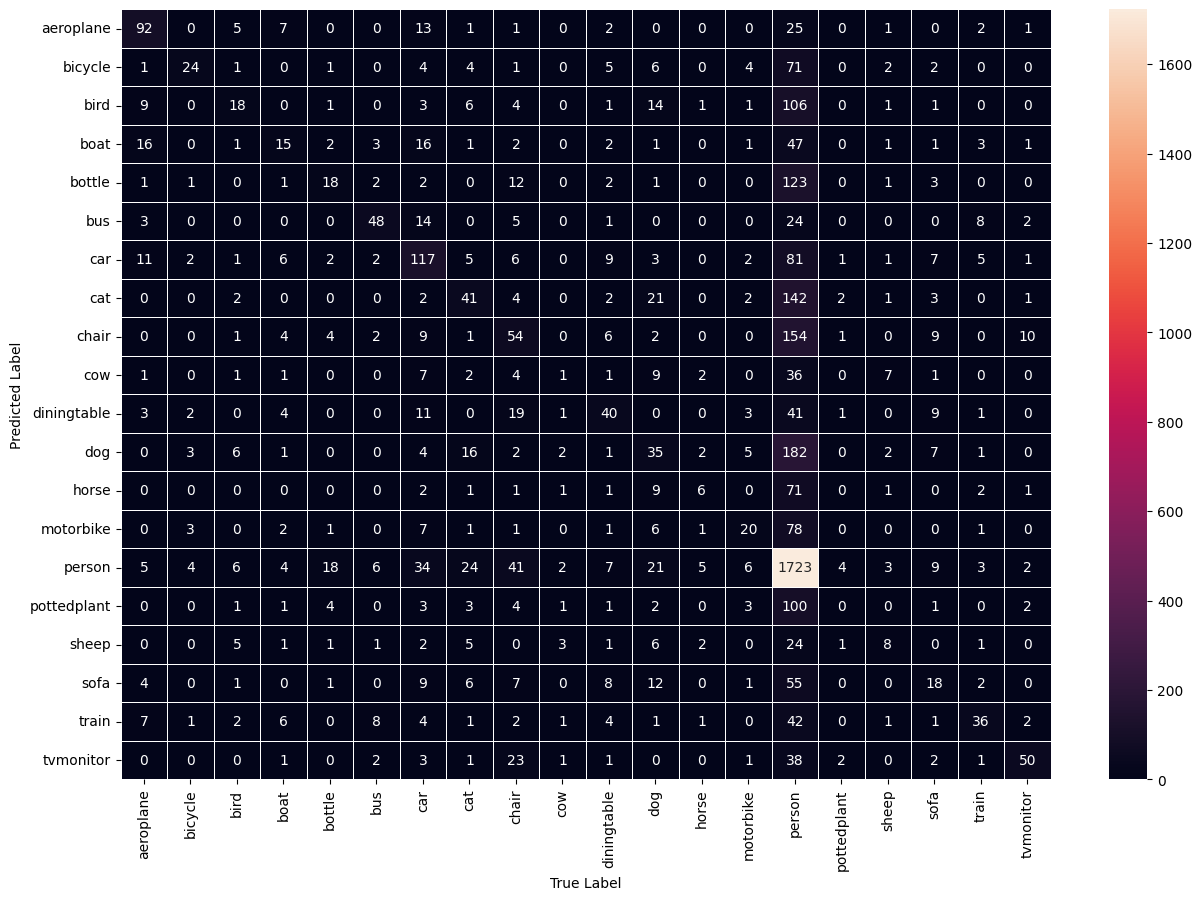

In [487]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [488]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.60      0.61      0.61       150
     bicycle       0.60      0.19      0.29       126
        bird       0.35      0.11      0.17       166
        boat       0.28      0.13      0.18       113
      bottle       0.34      0.11      0.16       167
         bus       0.65      0.46      0.54       105
         car       0.44      0.45      0.44       262
         cat       0.34      0.18      0.24       223
       chair       0.28      0.21      0.24       257
         cow       0.08      0.01      0.02        73
 diningtable       0.42      0.30      0.35       135
         dog       0.23      0.13      0.17       269
       horse       0.30      0.06      0.10        96
   motorbike       0.41      0.16      0.23       122
      person       0.54      0.89      0.68      1927
 pottedplant       0.00      0.00      0.00       126
       sheep       0.27      0.13      0.18        61
        sofa       0.24    

## SVM - HSV

In [489]:
x_train = pd.DataFrame(hsv_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(hsv_train_df['label']).to_numpy().ravel()

In [490]:
x_test = pd.DataFrame(hsv_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(hsv_test_df['label']).to_numpy().ravel()

In [491]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [492]:
pipe.score(x_test, y_test)

0.36057287278854255

In [493]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

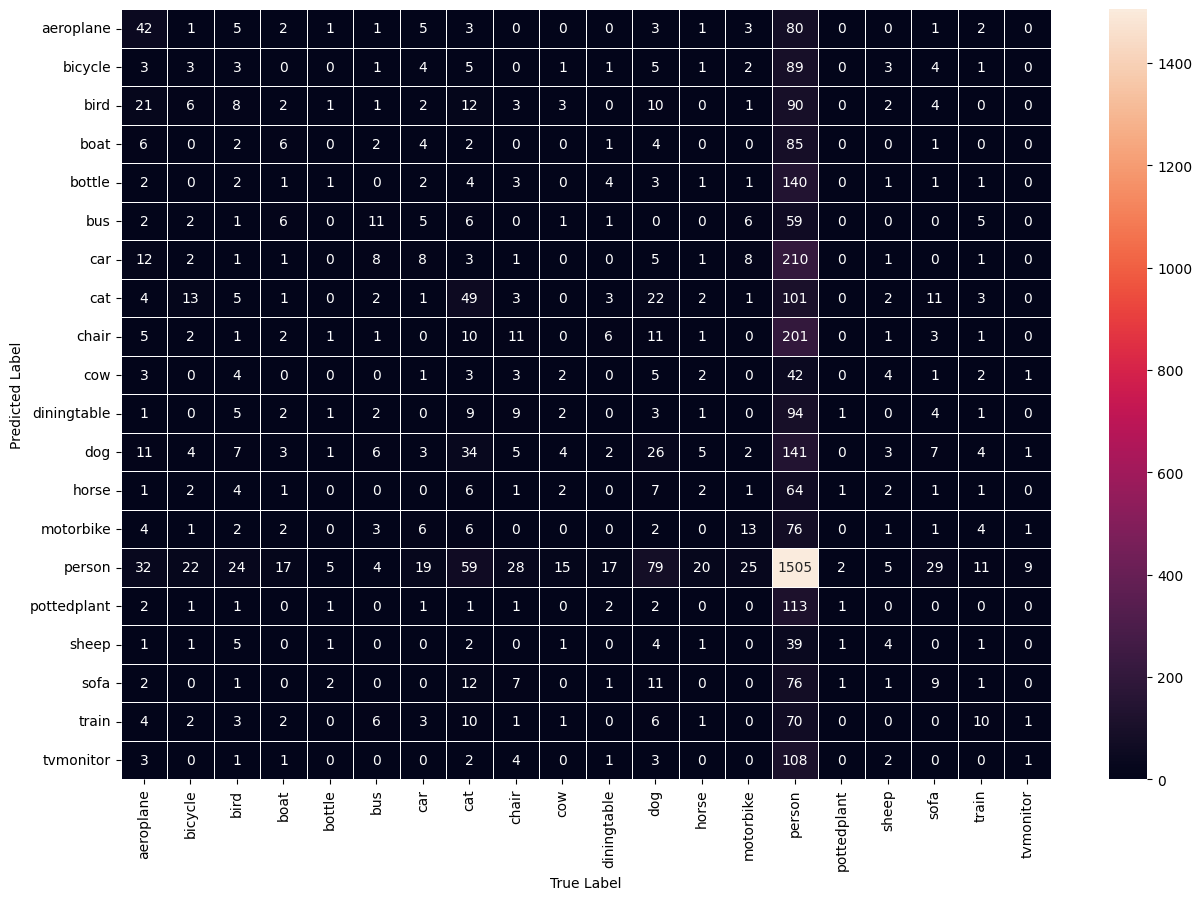

In [494]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [495]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.26      0.28      0.27       150
     bicycle       0.05      0.02      0.03       126
        bird       0.09      0.05      0.06       166
        boat       0.12      0.05      0.07       113
      bottle       0.07      0.01      0.01       167
         bus       0.23      0.10      0.14       105
         car       0.12      0.03      0.05       262
         cat       0.21      0.22      0.21       223
       chair       0.14      0.04      0.07       257
         cow       0.06      0.03      0.04        73
 diningtable       0.00      0.00      0.00       135
         dog       0.12      0.10      0.11       269
       horse       0.05      0.02      0.03        96
   motorbike       0.21      0.11      0.14       122
      person       0.44      0.78      0.57      1927
 pottedplant       0.14      0.01      0.02       126
       sheep       0.12      0.07      0.09        61
        sofa       0.12    

## SVM - SIFT

In [496]:
x_train = pd.DataFrame(sift_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(sift_train_df['label']).to_numpy().ravel()

In [497]:
x_test = pd.DataFrame(sift_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(sift_test_df['label']).to_numpy().ravel()

In [498]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [499]:
pipe.score(x_test, y_test)

0.40248525695029486

In [504]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

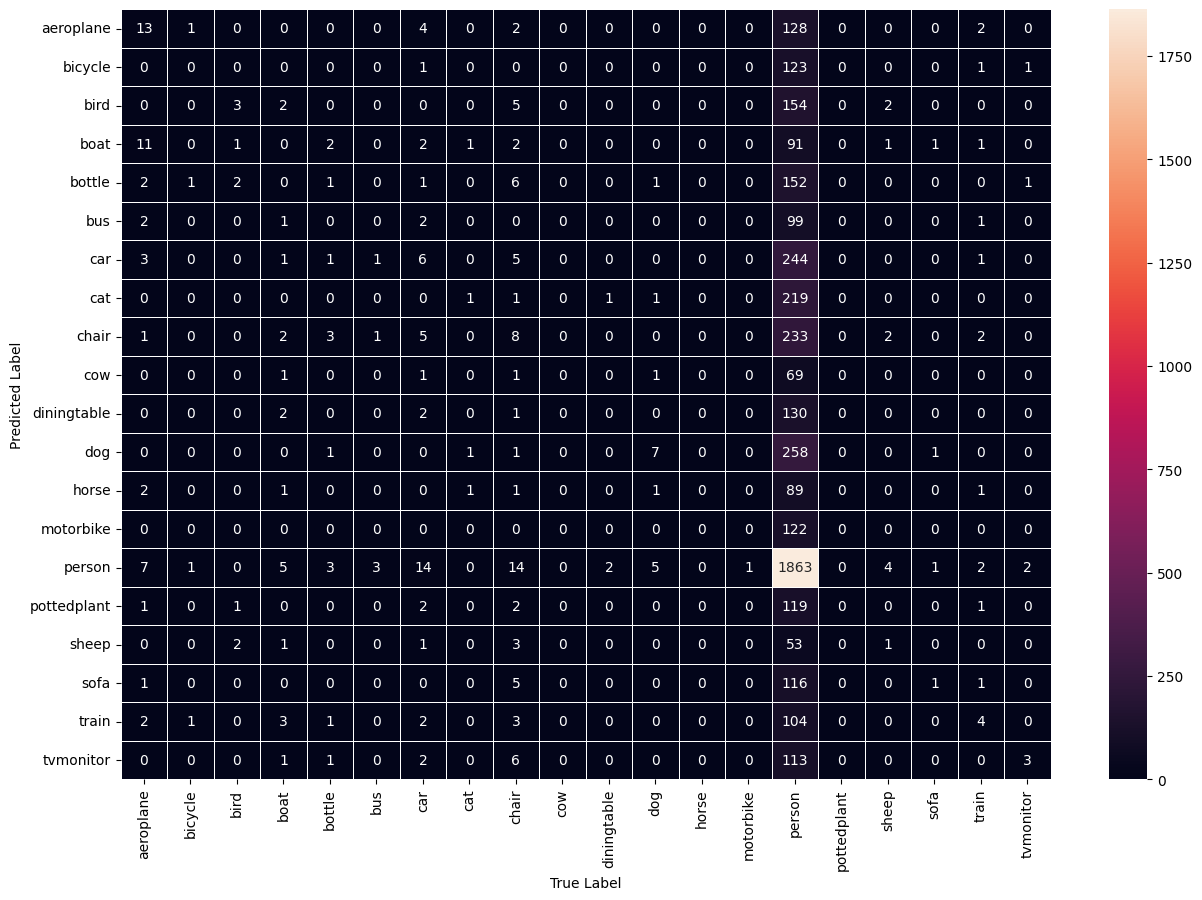

In [506]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [505]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.29      0.09      0.13       150
     bicycle       0.00      0.00      0.00       126
        bird       0.33      0.02      0.03       166
        boat       0.00      0.00      0.00       113
      bottle       0.08      0.01      0.01       167
         bus       0.00      0.00      0.00       105
         car       0.13      0.02      0.04       262
         cat       0.25      0.00      0.01       223
       chair       0.12      0.03      0.05       257
         cow       0.00      0.00      0.00        73
 diningtable       0.00      0.00      0.00       135
         dog       0.44      0.03      0.05       269
       horse       0.00      0.00      0.00        96
   motorbike       0.00      0.00      0.00       122
      person       0.42      0.97      0.58      1927
 pottedplant       0.00      0.00      0.00       126
       sheep       0.10      0.02      0.03        61
        sofa       0.25    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Checkpoint

In [11]:
# read in the train set
train_filepath = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/train_images_with_labels.csv'
train_df = pd.read_csv(train_filepath).drop(columns=['Unnamed: 0'])

# append the image data now to the train subset
train_df['image_data_unpadded'] = train_df.apply(lambda x: get_unpadded_image_data(x['filepath']), axis=1)
train_df['image_data_padded'] = train_df.apply(lambda x: get_padded_image_data(x['image_data_unpadded'], 128), axis=1)

train_df.head()

filename  \
0     2008_003463_person.jpg   
1  2009_003705_aeroplane.jpg   
2     2011_002063_person.jpg   
3     2008_002813_person.jpg   
4     2010_006952_person.jpg   

                                            filepath      label  \
0  /content/drive/MyDrive/DATASCI281_FinalProject...     person   
1  /content/drive/MyDrive/DATASCI281_FinalProject...  aeroplane   
2  /content/drive/MyDrive/DATASCI281_FinalProject...     person   
3  /content/drive/MyDrive/DATASCI281_FinalProject...     person   
4  /content/drive/MyDrive/DATASCI281_FinalProject...     person   

                                 image_data_unpadded  \
0  [[[133, 125, 114], [133, 125, 114], [135, 127,...   
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
2  [[[3, 3, 1], [3, 3, 1], [3, 3, 1], [3, 3, 1], ...   
3  [[[107, 105, 118], [96, 98, 110], [113, 121, 1...   
4  [[[52, 71, 88], [65, 84, 101], [69, 87, 107], ...   

                                   image_data_padded  
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
3  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...

In [22]:
# read in the test set
test_filepath = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/test_images_with_labels.csv'
test_df = pd.read_csv(test_filepath).drop(columns=['Unnamed: 0'])

# append the image data now to the test subset
test_df['image_data_unpadded'] = test_df.apply(lambda x: get_unpadded_image_data(x['filepath']), axis=1)
test_df['image_data_padded'] = test_df.apply(lambda x: get_padded_image_data(x['image_data_unpadded'], 128), axis=1)

test_df.head()

filename                                           filepath  \
0  2010_004506_person.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
1  2012_001337_person.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
2   2009_004942_horse.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
3    2010_003174_sofa.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
4  2008_002185_person.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   

    label                                image_data_unpadded  \
0  person  [[[101, 102, 106], [132, 135, 140], [105, 110,...   
1  person  [[[204, 203, 198], [204, 203, 198], [204, 203,...   
2   horse  [[[149, 169, 202], [149, 169, 202], [149, 169,...   
3    sofa  [[[13, 13, 15], [13, 13, 15], [13, 13, 15], [1...   
4  person  [[[188, 191, 184], [191, 193, 188], [182, 183,...   

                                   image_data_padded  
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
3  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...

# Effiency Optimization

## SVM - HOG Efficiency

In [16]:
# HOG
train_df['hog_vector'] = train_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded'], pixels_per_cell=24), axis=1)

# create hog vector df
hog_train_unsplit_df = train_df[['label','hog_vector']]
hog_train_unsplit_df.head()

num_hog_features = len(hog_train_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = train_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_train_temp_df = pd.DataFrame(hog_train_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_train_df = hog_train_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_train_df.to_csv('/content/final_train_hog_vectors.csv')

hog_train_df.head()

hog_1     hog_2     hog_3     hog_4     hog_5     hog_6     hog_7  \
0  0.029938  0.030081  0.000227  0.000000  0.309625  0.112070  0.021036   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.318981  0.104131  0.046168  0.013312  0.013276  0.008021  0.005928   
3  0.307906  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      hog_8     hog_9    hog_10  ...   hog_568   hog_569   hog_570   hog_571  \
0  0.017986  0.021336  0.025430  ...  0.058052  0.073865  0.056590  0.103494   
1  0.000000  0.000000  0.000000  ...  0.042141  0.010926  0.031043  0.061075   
2  0.012491  0.318981  0.231520  ...  0.331411  0.077478  0.175065  0.034970   
3  0.000000  0.212771  0.363429  ...  0.317136  0.000751  0.006176  0.001127   
4  0.000000  0.000000  0.410137  ...  0.397102  0.007818  0.007233  0.014660   

    hog_572   hog_573   hog_574   hog_575   hog_576      label  
0  0.516489  0.039684  0.008609  0.011517  0.025238     person  
1  0.257401  0.076917  0.040882  0.107635  0.064530  aeroplane  
2  0.055556  0.058260  0.029929  0.014953  0.168275     person  
3  0.010917  0.001878  0.005938  0.000376  0.317136     person  
4  0.005608  0.017178  0.026002  0.026217  0.397102     person  

[5 rows x 577 columns]

In [17]:
# HOG
test_df['hog_vector'] = test_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded'], pixels_per_cell=24), axis=1)

# create hog vector df
hog_test_unsplit_df = test_df[['label','hog_vector']]
hog_test_unsplit_df.head()

hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = test_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_test_temp_df = pd.DataFrame(hog_test_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_test_df = hog_test_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_test_df.to_csv('/content/final_test_hog_vectors.csv')

hog_test_df.head()

hog_1     hog_2     hog_3     hog_4     hog_5     hog_6     hog_7  \
0  0.094252  0.074127  0.201959  0.322563  0.322563  0.103802  0.094590   
1  0.037058  0.057688  0.063016  0.086700  0.299539  0.105314  0.134890   
2  0.062611  0.027425  0.051485  0.204670  0.371546  0.083735  0.065716   
3  0.601374  0.019290  0.012278  0.012267  0.017725  0.019560  0.011316   
4  0.293544  0.011261  0.023112  0.027999  0.027104  0.035181  0.135791   

      hog_8     hog_9    hog_10  ...   hog_568   hog_569   hog_570   hog_571  \
0  0.056391  0.052716  0.021016  ...  0.062777  0.067659  0.100147  0.257760   
1  0.042281  0.018627  0.299539  ...  0.001210  0.000601  0.027769  0.026764   
2  0.028807  0.034462  0.021032  ...  0.099353  0.108089  0.172646  0.238217   
3  0.019055  0.206720  0.066162  ...  0.281474  0.059115  0.091592  0.204385   
4  0.204989  0.293544  0.251130  ...  0.131401  0.224726  0.261916  0.137583   

    hog_572   hog_573   hog_574   hog_575   hog_576   label  
0  0.248954  0.215524  0.082343  0.074411  0.031001  person  
1  0.258296  0.006835  0.004393  0.001387  0.000851  person  
2  0.205795  0.160928  0.157111  0.166616  0.099131   horse  
3  0.281474  0.281474  0.187416  0.125878  0.281474    sofa  
4  0.025356  0.006913  0.072433  0.059312  0.167925  person  

[5 rows x 577 columns]

In [18]:
x_train = pd.DataFrame(hog_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(hog_train_df['label']).to_numpy().ravel()

In [19]:
x_test = pd.DataFrame(hog_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(hog_test_df['label']).to_numpy().ravel()

In [20]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [21]:
pipe.score(x_test, y_test)

0.4829401853411963

In [22]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

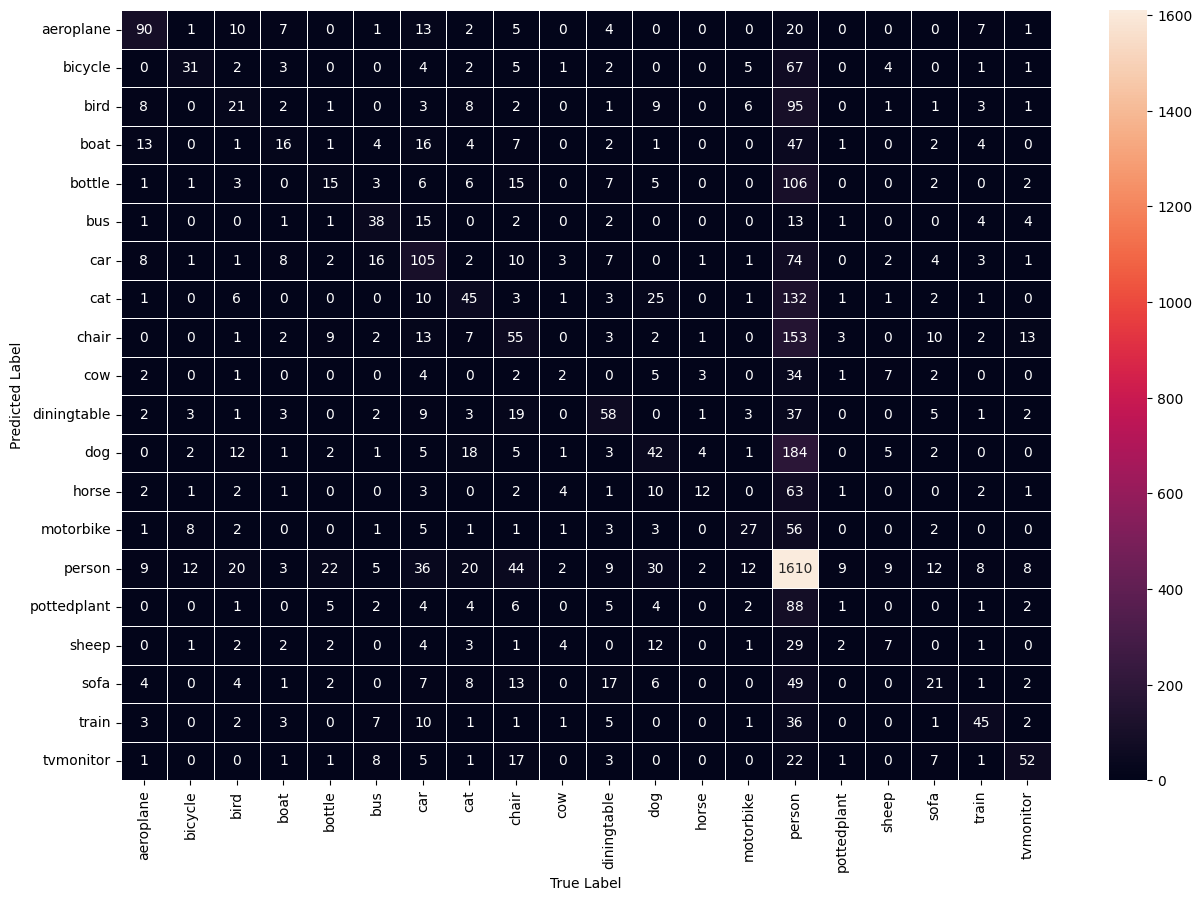

In [23]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.62      0.56      0.59       161
     bicycle       0.51      0.24      0.33       128
        bird       0.23      0.13      0.17       162
        boat       0.30      0.13      0.18       119
      bottle       0.24      0.09      0.13       172
         bus       0.42      0.46      0.44        82
         car       0.38      0.42      0.40       249
         cat       0.33      0.19      0.25       232
       chair       0.26      0.20      0.22       276
         cow       0.10      0.03      0.05        63
 diningtable       0.43      0.39      0.41       149
         dog       0.27      0.15      0.19       288
       horse       0.50      0.11      0.19       105
   motorbike       0.45      0.24      0.32       111
      person       0.55      0.86      0.67      1882
 pottedplant       0.05      0.01      0.01       125
       sheep       0.19      0.10      0.13        71
        sofa       0.29    

# Accuracy Optimization

## SVM - HOG Accuracy Attempt #1

In [25]:
# HOG
train_df['hog_vector'] = train_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded'], pixels_per_cell=8), axis=1)

# create hog vector df
hog_train_unsplit_df = train_df[['label','hog_vector']]
hog_train_unsplit_df.head()

num_hog_features = len(hog_train_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = train_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_train_temp_df = pd.DataFrame(hog_train_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_train_df = hog_train_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_train_df.to_csv('/content/final_train_hog_vectors.csv')

hog_train_df.head()

hog_1  hog_2  hog_3  hog_4  hog_5  hog_6  hog_7  hog_8  hog_9    hog_10  \
0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
1  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
2  0.074984    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.497144   
3  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
4  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   

   ...  hog_8092  hog_8093  hog_8094  hog_8095  hog_8096  hog_8097  hog_8098  \
0  ...  0.000000       0.0       0.0       0.0       0.0       0.0       0.0   
1  ...  0.000000       0.0       0.0       0.0       0.0       0.0       0.0   
2  ...  0.060955       0.0       0.0       0.0       0.0       0.0       0.0   
3  ...  0.000000       0.0       0.0       0.0       0.0       0.0       0.0   
4  ...  0.000000       0.0       0.0       0.0       0.0       0.0       0.0   

   hog_8099  hog_8100      label  
0       0.0       0.0     person  
1       0.0       0.0  aeroplane  
2       0.0       0.0     person  
3       0.0       0.0     person  
4       0.0       0.0     person  

[5 rows x 8101 columns]

In [26]:
# HOG
test_df['hog_vector'] = test_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded'], pixels_per_cell=8), axis=1)

# create hog vector df
hog_test_unsplit_df = test_df[['label','hog_vector']]
hog_test_unsplit_df.head()

hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = test_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_test_temp_df = pd.DataFrame(hog_test_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_test_df = hog_test_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_test_df.to_csv('/content/final_test_hog_vectors.csv')

hog_test_df.head()

hog_1     hog_2    hog_3     hog_4     hog_5     hog_6     hog_7  \
0  0.073125  0.084623  0.04774  0.236667  0.318650  0.063236  0.266443   
1  0.000000  0.000000  0.00000  0.000000  0.495279  0.000000  0.000000   
2  0.000000  0.000000  0.00000  0.000000  0.660470  0.000000  0.000000   
3  0.074635  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
4  0.389942  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   

      hog_8    hog_9    hog_10  ...  hog_8092  hog_8093  hog_8094  hog_8095  \
0  0.165859  0.02663  0.092818  ...  0.000000  0.000000       0.0  0.000000   
1  0.000000  0.00000  0.000000  ...  0.000000  0.000000       0.0  0.000000   
2  0.000000  0.00000  0.000000  ...  0.000000  0.007813       0.0  0.034201   
3  0.000000  0.00000  0.587273  ...  0.079001  0.000000       0.0  0.000000   
4  0.000000  0.00000  0.389942  ...  0.387110  0.000000       0.0  0.000000   

   hog_8096  hog_8097  hog_8098  hog_8099  hog_8100   label  
0  0.594274  0.141482  0.035192  0.000000   0.00000  person  
1  0.496246  0.000000  0.000000  0.000000   0.00000  person  
2  0.589633  0.055219  0.016698  0.015446   0.00000   horse  
3  0.000000  0.000000  0.000000  0.000000   0.00000    sofa  
4  0.000000  0.000000  0.000000  0.000000   0.38711  person  

[5 rows x 8101 columns]

In [27]:
x_train = pd.DataFrame(hog_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(hog_train_df['label']).to_numpy().ravel()

In [28]:
x_test = pd.DataFrame(hog_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(hog_test_df['label']).to_numpy().ravel()

In [30]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [31]:
pipe.score(x_test, y_test)

0.4833614153327717

In [32]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

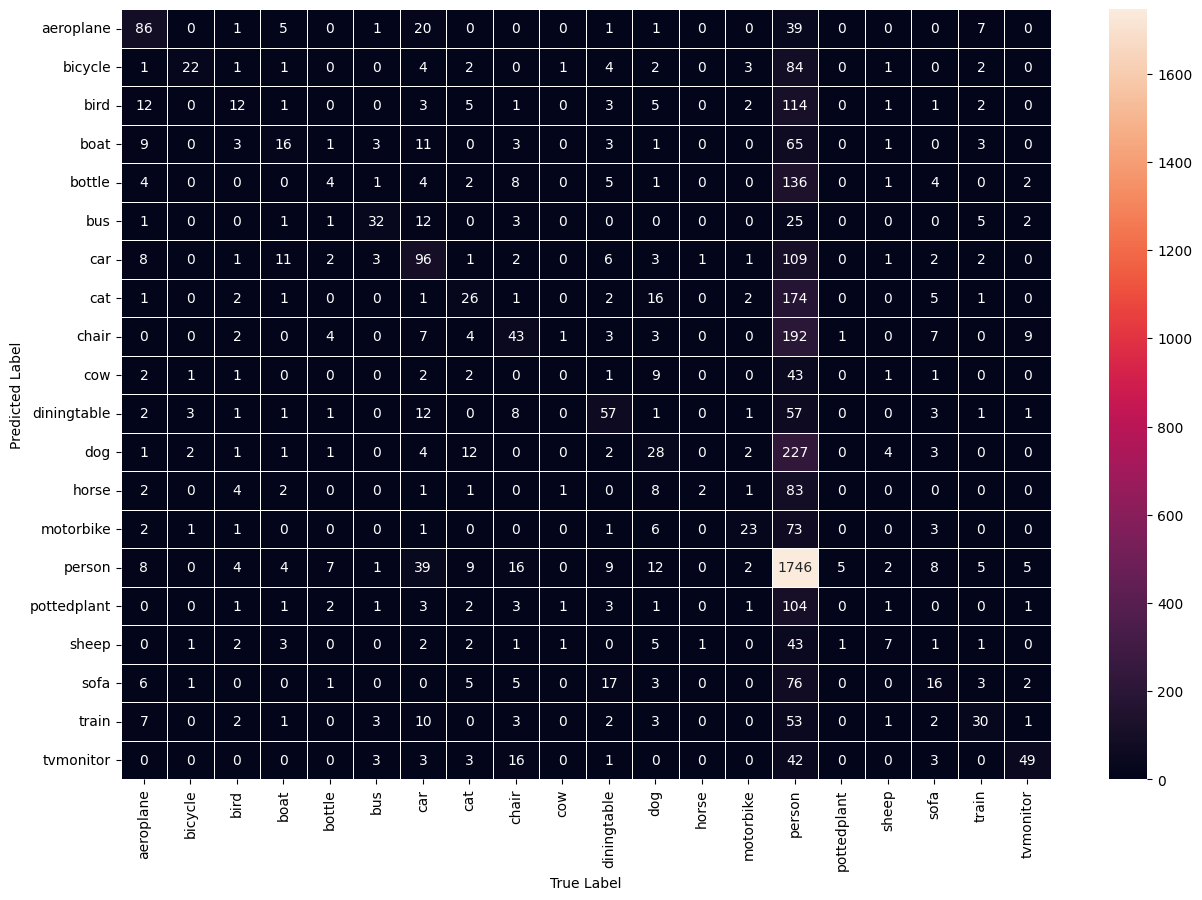

In [33]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.57      0.53      0.55       161
     bicycle       0.71      0.17      0.28       128
        bird       0.31      0.07      0.12       162
        boat       0.33      0.13      0.19       119
      bottle       0.17      0.02      0.04       172
         bus       0.67      0.39      0.49        82
         car       0.41      0.39      0.40       249
         cat       0.34      0.11      0.17       232
       chair       0.38      0.16      0.22       276
         cow       0.00      0.00      0.00        63
 diningtable       0.47      0.38      0.42       149
         dog       0.26      0.10      0.14       288
       horse       0.50      0.02      0.04       105
   motorbike       0.61      0.21      0.31       111
      person       0.50      0.93      0.65      1882
 pottedplant       0.00      0.00      0.00       125
       sheep       0.33      0.10      0.15        71
        sofa       0.27    

## SVM - HOG Accuracy Attempt #2

In [14]:
# HOG
train_df['hog_vector'] = train_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded'], pixels_per_cell=12), axis=1)

# create hog vector df
hog_train_unsplit_df = train_df[['label','hog_vector']]
hog_train_unsplit_df.head()

num_hog_features = len(hog_train_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = train_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_train_temp_df = pd.DataFrame(hog_train_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_train_df = hog_train_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_train_df.to_csv('/content/final_train_hog_vectors.csv')

hog_train_df.head()

hog_1  hog_2  hog_3  hog_4  hog_5  hog_6  hog_7  hog_8     hog_9  \
0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
1  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
2  0.469724    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.393351   
3  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
4  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   

     hog_10  ...  hog_2908  hog_2909  hog_2910  hog_2911  hog_2912  hog_2913  \
0  0.000000  ...    0.0000  0.000000  0.000000   0.00000  0.473659  0.000000   
1  0.000000  ...    0.0000  0.000000  0.000000   0.00000  0.000000  0.000000   
2  0.029873  ...    0.4165  0.022856  0.002049   0.02946  0.137969  0.125881   
3  0.500000  ...    0.0000  0.000000  0.000000   0.00000  0.000000  0.000000   
4  0.000000  ...    0.0000  0.000000  0.000000   0.00000  0.000000  0.000000   

   hog_2914  hog_2915  hog_2916      label  
0  0.000000   0.00000  0.000000     person  
1  0.000000   0.00000  0.000000  aeroplane  
2  0.040843   0.01977  0.254249     person  
3  0.000000   0.00000  0.000000     person  
4  0.000000   0.00000  0.000000     person  

[5 rows x 2917 columns]

In [15]:
# HOG
test_df['hog_vector'] = test_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded'], pixels_per_cell=12), axis=1)

# create hog vector df
hog_test_unsplit_df = test_df[['label','hog_vector']]
hog_test_unsplit_df.head()

hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = test_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_test_temp_df = pd.DataFrame(hog_test_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_test_df = hog_test_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_test_df.to_csv('/content/final_test_hog_vectors.csv')

hog_test_df.head()

hog_1     hog_2     hog_3     hog_4     hog_5     hog_6     hog_7  \
0  0.196922  0.144350  0.138186  0.179159  0.362407  0.095162  0.240619   
1  0.001249  0.002793  0.006182  0.000000  0.337456  0.015242  0.004503   
2  0.025409  0.017354  0.033871  0.081078  0.562541  0.013997  0.029085   
3  0.648701  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.343085  0.000000  0.003924  0.023739  0.000000  0.000000  0.020594   

      hog_8     hog_9    hog_10  ...  hog_2908  hog_2909  hog_2910  hog_2911  \
0  0.150206  0.052777  0.005835  ...  0.058754  0.065490  0.122457  0.133026   
1  0.000000  0.000000  0.001249  ...  0.000000  0.000000  0.109477  0.121246   
2  0.000000  0.014812  0.028678  ...  0.106431  0.134576  0.133139  0.195186   
3  0.000000  0.354571  0.097091  ...  0.281601  0.001795  0.027058  0.022227   
4  0.004941  0.343085  0.168878  ...  0.316445  0.136429  0.050001  0.025968   

   hog_2912  hog_2913  hog_2914  hog_2915  hog_2916   label  
0  0.286955  0.306887  0.190767  0.200625  0.113873  person  
1  0.595932  0.054478  0.003421  0.000000  0.000000  person  
2  0.140136  0.142078  0.247110  0.247110  0.088924   horse  
3  0.209541  0.177277  0.046954  0.116050  0.281601    sofa  
4  0.015289  0.009784  0.012061  0.035957  0.335662  person  

[5 rows x 2917 columns]

In [16]:
x_train = pd.DataFrame(hog_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(hog_train_df['label']).to_numpy().ravel()

In [17]:
x_test = pd.DataFrame(hog_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(hog_test_df['label']).to_numpy().ravel()

In [18]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [19]:
pipe.score(x_test, y_test)

0.4909435551811289

In [20]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

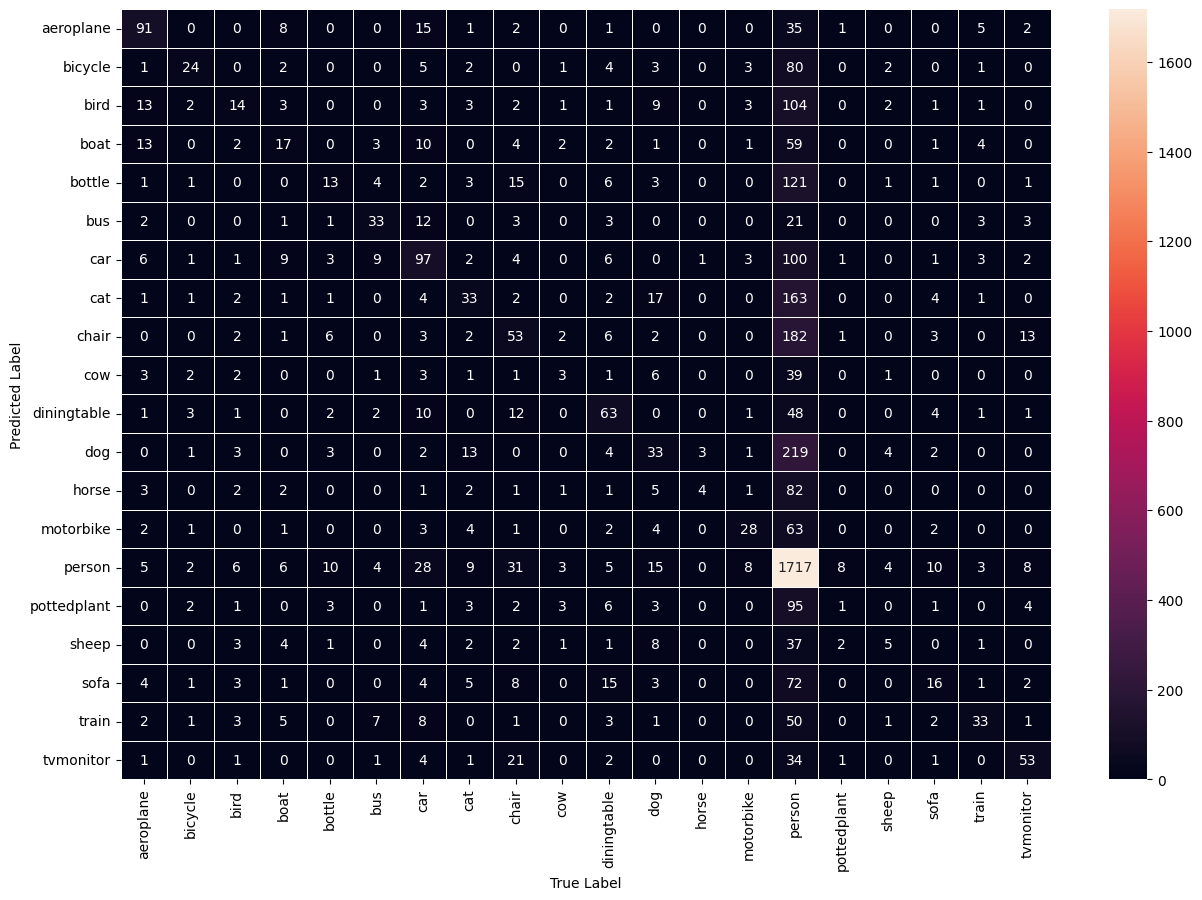

In [21]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.61      0.57      0.59       161
     bicycle       0.57      0.19      0.28       128
        bird       0.30      0.09      0.13       162
        boat       0.28      0.14      0.19       119
      bottle       0.30      0.08      0.12       172
         bus       0.52      0.40      0.45        82
         car       0.44      0.39      0.41       249
         cat       0.38      0.14      0.21       232
       chair       0.32      0.19      0.24       276
         cow       0.18      0.05      0.07        63
 diningtable       0.47      0.42      0.45       149
         dog       0.29      0.11      0.16       288
       horse       0.50      0.04      0.07       105
   motorbike       0.57      0.25      0.35       111
      person       0.52      0.91      0.66      1882
 pottedplant       0.07      0.01      0.01       125
       sheep       0.25      0.07      0.11        71
        sofa       0.33    

## SVM - HOG Accuracy Attempt #3

In [23]:
# HOG
train_df['hog_vector'] = train_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded'], pixels_per_cell=20), axis=1)

# create hog vector df
hog_train_unsplit_df = train_df[['label','hog_vector']]
hog_train_unsplit_df.head()

num_hog_features = len(hog_train_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = train_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_train_temp_df = pd.DataFrame(hog_train_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_train_df = hog_train_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_train_df.to_csv('/content/final_train_hog_vectors.csv')

hog_train_df.head()

hog_1     hog_2     hog_3     hog_4     hog_5     hog_6     hog_7  \
0  0.000000  0.000000  0.000000  0.000000  0.330256  0.053138  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.330317  0.036257  0.011813  0.006463  0.005941  0.001598  0.001867   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

     hog_8     hog_9    hog_10  ...   hog_892   hog_893   hog_894   hog_895  \
0  0.00000  0.000000  0.000000  ...  0.061096  0.061596  0.025690  0.014917   
1  0.00000  0.000000  0.000000  ...  0.011851  0.002105  0.025254  0.043928   
2  0.00059  0.330317  0.228148  ...  0.396063  0.092747  0.063797  0.020511   
3  0.00000  0.000000  0.472906  ...  0.311746  0.000491  0.002173  0.000491   
4  0.00000  0.000000  0.458975  ...  0.347306  0.000000  0.000000  0.000000   

    hog_896   hog_897   hog_898   hog_899   hog_900      label  
0  0.577759  0.045860  0.011206  0.006517  0.017613     person  
1  0.272565  0.112425  0.052769  0.057504  0.018644  aeroplane  
2  0.066426  0.073883  0.037813  0.015751  0.215950     person  
3  0.002853  0.000000  0.000310  0.000000  0.311746     person  
4  0.000000  0.000000  0.000000  0.000000  0.347306     person  

[5 rows x 901 columns]

In [24]:
# HOG
test_df['hog_vector'] = test_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded'], pixels_per_cell=20), axis=1)

# create hog vector df
hog_test_unsplit_df = test_df[['label','hog_vector']]
hog_test_unsplit_df.head()

hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = test_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_test_temp_df = pd.DataFrame(hog_test_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_test_df = hog_test_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_test_df.to_csv('/content/final_test_hog_vectors.csv')

hog_test_df.head()

hog_1     hog_2     hog_3     hog_4     hog_5     hog_6     hog_7  \
0  0.111921  0.099467  0.154346  0.254306  0.328778  0.141884  0.125974   
1  0.008058  0.004240  0.049659  0.136202  0.292126  0.125498  0.049053   
2  0.055739  0.025752  0.028790  0.136445  0.401368  0.084934  0.076731   
3  0.653793  0.021263  0.010128  0.014923  0.013033  0.017935  0.011219   
4  0.313723  0.009077  0.028218  0.027898  0.034759  0.036024  0.183807   

      hog_8     hog_9    hog_10  ...   hog_892   hog_893   hog_894   hog_895  \
0  0.065624  0.024206  0.020113  ...  0.057106  0.056831  0.114402  0.241936   
1  0.000515  0.000000  0.015426  ...  0.000198  0.000442  0.029077  0.022911   
2  0.034358  0.030764  0.026583  ...  0.073249  0.115262  0.112984  0.232377   
3  0.022672  0.264473  0.056795  ...  0.263537  0.023879  0.050182  0.095926   
4  0.170359  0.313723  0.172311  ...  0.173868  0.092510  0.244092  0.025311   

    hog_896   hog_897   hog_898   hog_899   hog_900   label  
0  0.265057  0.265426  0.099721  0.085178  0.044069  person  
1  0.321742  0.006586  0.002796  0.000000  0.000000  person  
2  0.222408  0.155738  0.190481  0.202907  0.098967   horse  
3  0.263537  0.263537  0.156770  0.097061  0.263537    sofa  
4  0.010136  0.008150  0.103588  0.084091  0.246291  person  

[5 rows x 901 columns]

In [25]:
x_train = pd.DataFrame(hog_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(hog_train_df['label']).to_numpy().ravel()

In [26]:
x_test = pd.DataFrame(hog_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(hog_test_df['label']).to_numpy().ravel()

In [27]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [28]:
pipe.score(x_test, y_test)

0.4896798652064027

In [29]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

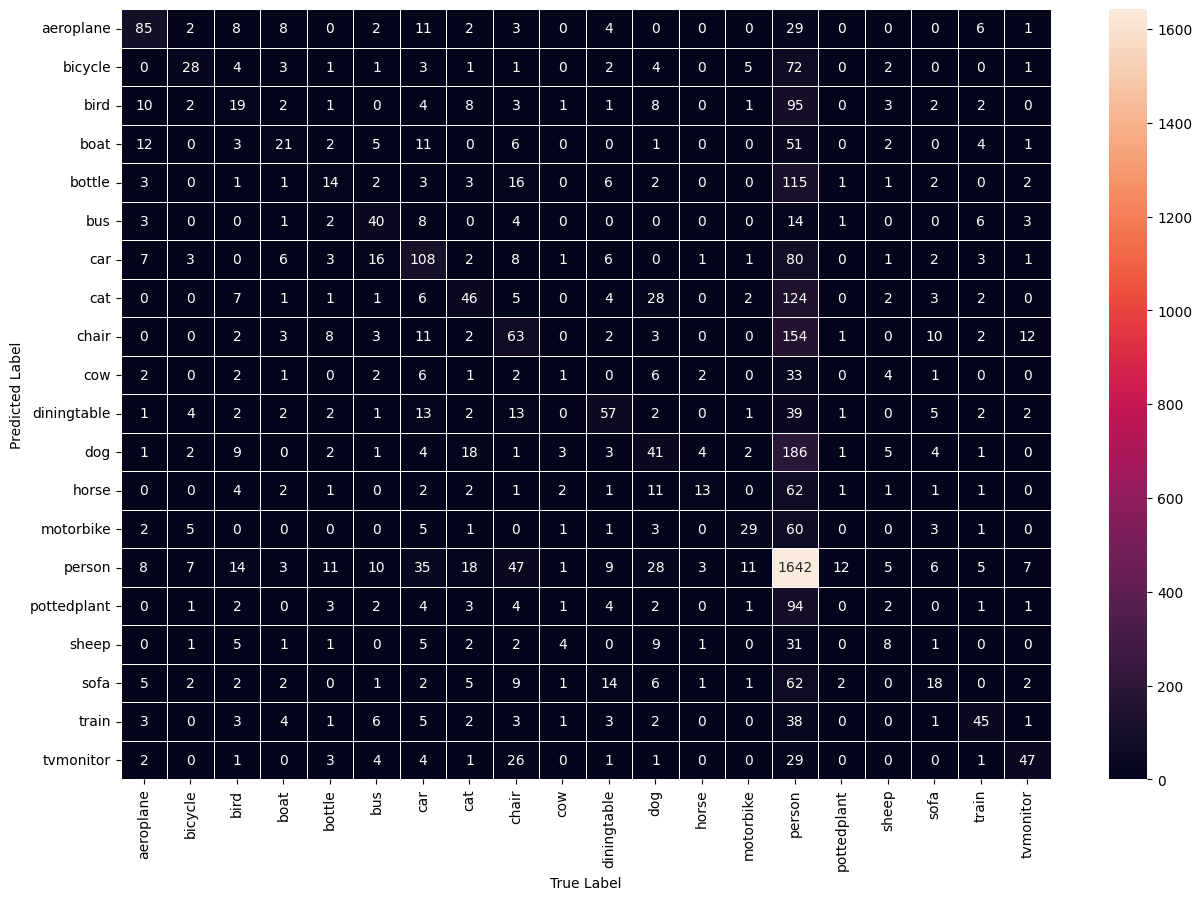

In [30]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.59      0.53      0.56       161
     bicycle       0.49      0.22      0.30       128
        bird       0.22      0.12      0.15       162
        boat       0.34      0.18      0.23       119
      bottle       0.25      0.08      0.12       172
         bus       0.41      0.49      0.45        82
         car       0.43      0.43      0.43       249
         cat       0.39      0.20      0.26       232
       chair       0.29      0.23      0.26       276
         cow       0.06      0.02      0.02        63
 diningtable       0.48      0.38      0.43       149
         dog       0.26      0.14      0.18       288
       horse       0.52      0.12      0.20       105
   motorbike       0.54      0.26      0.35       111
      person       0.55      0.87      0.67      1882
 pottedplant       0.00      0.00      0.00       125
       sheep       0.22      0.11      0.15        71
        sofa       0.31    

## SVM - HOG Accuracy Attempt #4

In [32]:
# HOG
train_df['hog_vector'] = train_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded'], cells_per_block=4), axis=1)

# create hog vector df
hog_train_unsplit_df = train_df[['label','hog_vector']]
hog_train_unsplit_df.head()

num_hog_features = len(hog_train_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = train_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_train_temp_df = pd.DataFrame(hog_train_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_train_df = hog_train_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_train_df.to_csv('/content/final_train_hog_vectors.csv')

hog_train_df.head()

hog_1     hog_2     hog_3     hog_4     hog_5     hog_6     hog_7  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.229047  0.000159  0.000903  0.000317  0.001632  0.000476  0.000201   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

   hog_8     hog_9    hog_10  ...  hog_3592  hog_3593  hog_3594  hog_3595  \
0    0.0  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1    0.0  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2    0.0  0.163177  0.042984  ...  0.233363  0.022082  0.009361  0.019454   
3    0.0  0.000000  0.272048  ...  0.000000  0.000000  0.000000  0.000000   
4    0.0  0.000000  0.254025  ...  0.000000  0.000000  0.000000  0.000000   

   hog_3596  hog_3597  hog_3598  hog_3599  hog_3600      label  
0  0.000000  0.000000   0.00000  0.000000  0.000000     person  
1  0.000000  0.000000   0.00000  0.000000  0.000000  aeroplane  
2  0.030045  0.032974   0.00553  0.002657  0.072636     person  
3  0.000000  0.000000   0.00000  0.000000  0.000000     person  
4  0.000000  0.000000   0.00000  0.000000  0.000000     person  

[5 rows x 3601 columns]

In [33]:
# HOG
test_df['hog_vector'] = test_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded'], cells_per_block=4), axis=1)

# create hog vector df
hog_test_unsplit_df = test_df[['label','hog_vector']]
hog_test_unsplit_df.head()

hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = test_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_test_temp_df = pd.DataFrame(hog_test_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_test_df = hog_test_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_test_df.to_csv('/content/final_test_hog_vectors.csv')

hog_test_df.head()

hog_1     hog_2     hog_3     hog_4     hog_5     hog_6     hog_7  \
0  0.047582  0.038848  0.067117  0.104933  0.256791  0.071600  0.066564   
1  0.001508  0.000937  0.004148  0.001124  0.138812  0.002607  0.000960   
2  0.009461  0.006927  0.011682  0.032569  0.295591  0.034649  0.032704   
3  0.325384  0.001824  0.001240  0.000000  0.001315  0.003828  0.001480   
4  0.226081  0.000000  0.010520  0.015641  0.016694  0.007609  0.038658   

      hog_8     hog_9    hog_10  ...  hog_3592  hog_3593  hog_3594  hog_3595  \
0  0.035611  0.012513  0.001221  ...  0.010330  0.005158  0.001971  0.002605   
1  0.000000  0.000000  0.001592  ...  0.001741  0.001588  0.003115  0.006377   
2  0.015200  0.005957  0.021171  ...  0.017986  0.023146  0.019329  0.020805   
3  0.004845  0.096174  0.032565  ...  0.240215  0.000240  0.001820  0.001468   
4  0.022374  0.226081  0.026196  ...  0.229979  0.024617  0.042041  0.005542   

   hog_3596  hog_3597  hog_3598  hog_3599  hog_3600   label  
0  0.345604  0.150544  0.040250  0.023130  0.014269  person  
1  0.256961  0.003321  0.000397  0.001191  0.000000  person  
2  0.290774  0.081458  0.052307  0.028475  0.013930   horse  
3  0.000858  0.001026  0.001365  0.000480  0.240215    sofa  
4  0.004930  0.000518  0.000475  0.001133  0.229979  person  

[5 rows x 3601 columns]

In [34]:
x_train = pd.DataFrame(hog_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(hog_train_df['label']).to_numpy().ravel()

In [35]:
x_test = pd.DataFrame(hog_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(hog_test_df['label']).to_numpy().ravel()

In [36]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [37]:
pipe.score(x_test, y_test)

0.4865206402695872

In [38]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

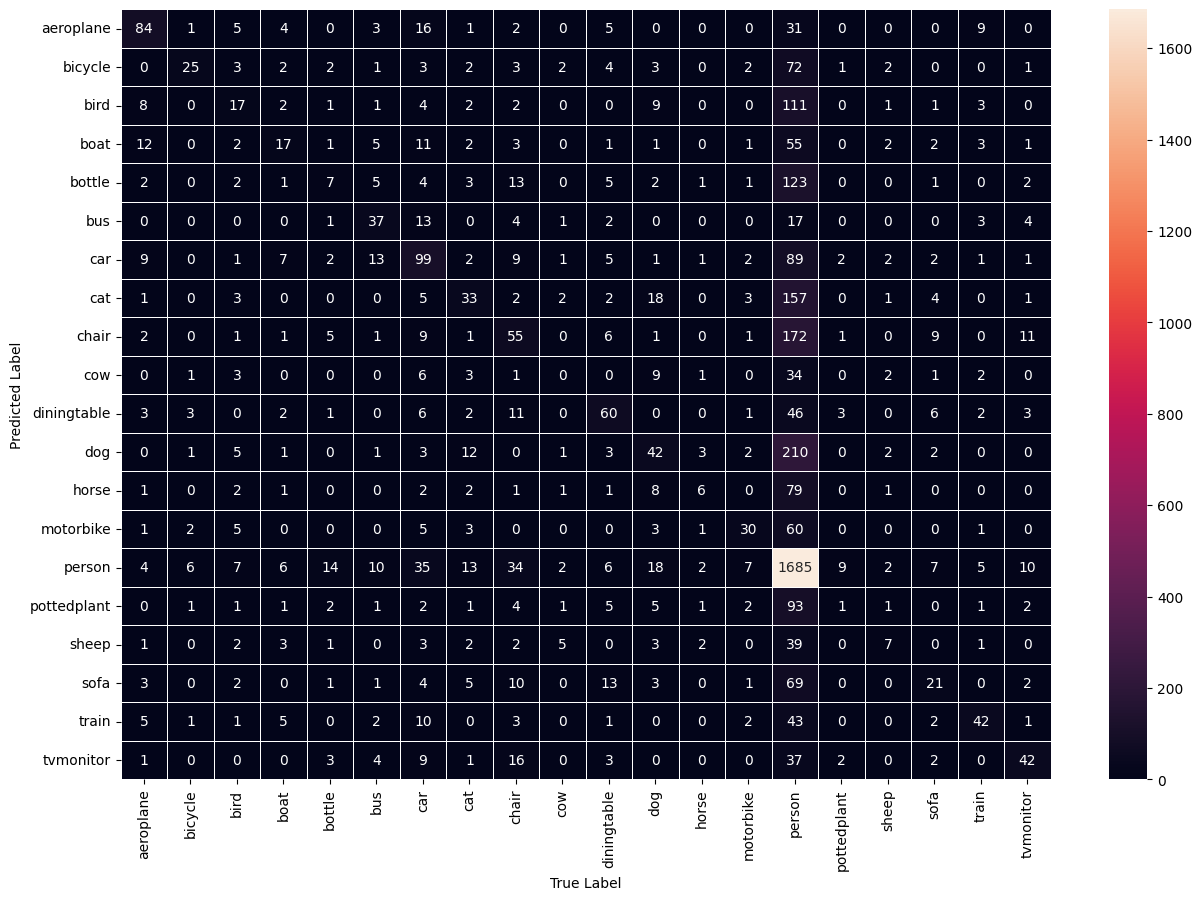

In [39]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.61      0.52      0.56       161
     bicycle       0.61      0.20      0.30       128
        bird       0.27      0.10      0.15       162
        boat       0.32      0.14      0.20       119
      bottle       0.17      0.04      0.07       172
         bus       0.44      0.45      0.44        82
         car       0.40      0.40      0.40       249
         cat       0.37      0.14      0.20       232
       chair       0.31      0.20      0.24       276
         cow       0.00      0.00      0.00        63
 diningtable       0.49      0.40      0.44       149
         dog       0.33      0.15      0.20       288
       horse       0.33      0.06      0.10       105
   motorbike       0.55      0.27      0.36       111
      person       0.52      0.90      0.66      1882
 pottedplant       0.05      0.01      0.01       125
       sheep       0.30      0.10      0.15        71
        sofa       0.35    

# Test on ITO-EN Public Domain Images

## Process Public Domain Images

(128, 128, 3)


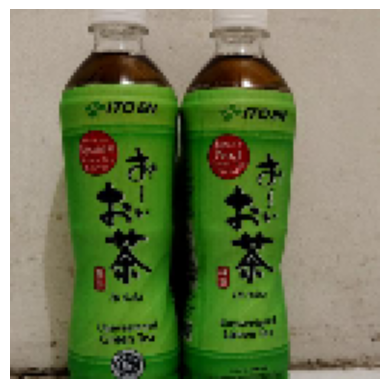

In [12]:
# load test image
PUBLIC_DOMAIN_IMAGE_PATH = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/00_PHASE0_AUG_W281_ITO-EN_Images/'
image_file_path = PUBLIC_DOMAIN_IMAGE_PATH + 'ZYQ5OOFL02_augmented_brightness_0.jpg'

try:
    I = np.asarray(PIL.Image.open(image_file_path).convert('RGB'))
    image_padded = resize_with_pad(I, (128, 128))
    plt.axis('off')
    plt.imshow(image_padded)
    print(image_padded.shape)
except FileNotFoundError:
    print('image not found')

In [13]:
# list out the SYNTHETIC files
public_domain_files = os.listdir(PUBLIC_DOMAIN_IMAGE_PATH)
print(len(public_domain_files))
public_domain_files[:5]

516


['KCFRAHDK6G_augmented_contrast_0.jpg',
 'OV6HHL57XK_augmented_brightness_0.jpg',
 'VKYDB156C4_augmented_hue_0.jpg',
 'KRAEI1FC8R_augmented_saturation_0.jpg',
 'JT4F909LCK_augmented_contrast_1.jpg']

In [14]:
# get all objects from the images and append the bottle label

output_path = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/ALL_ITO-EN_IMAGES_RESIZED/'

for image in public_domain_files:    
    I = np.asarray(PIL.Image.open(PUBLIC_DOMAIN_IMAGE_PATH + '/' + image).convert('RGB'))
    image_padded = resize_with_pad(I, (128, 128))
    im = Image.fromarray(image_padded)
    im.save(output_path + image.split('.')[0] + '_bottle.jpg')

In [15]:
# filepath = '/content/'
filepath = '/content/drive/MyDrive/DATASCI281_FinalProject/00_datasets/ALL_ITO-EN_IMAGES_RESIZED/'

# list out the image files
cropped_filenames = os.listdir(filepath)

filenames = []

for file in os.listdir(filepath):
    if file.endswith('.jpg'):
        filenames.append(file)

print(len(filenames))
filenames[:5]

516


['KCFRAHDK6G_augmented_contrast_0_bottle.jpg',
 'VKYDB156C4_augmented_hue_0_bottle.jpg',
 'OV6HHL57XK_augmented_brightness_0_bottle.jpg',
 'JT4F909LCK_augmented_contrast_1_bottle.jpg',
 'KRAEI1FC8R_augmented_saturation_0_bottle.jpg']

In [16]:
# add filenames to a dataframe
image_df = pd.DataFrame({'filename':filenames})

# get full filepath
image_df['filepath'] = filepath + image_df['filename']

# get label
image_df['label'] = image_df.apply(lambda x: get_label_from_cropped_filename(x['filename']), axis=1)

image_df.head()

filename  \
0    KCFRAHDK6G_augmented_contrast_0_bottle.jpg   
1         VKYDB156C4_augmented_hue_0_bottle.jpg   
2  OV6HHL57XK_augmented_brightness_0_bottle.jpg   
3    JT4F909LCK_augmented_contrast_1_bottle.jpg   
4  KRAEI1FC8R_augmented_saturation_0_bottle.jpg   

                                            filepath   label  
0  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle  
1  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle  
2  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle  
3  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle  
4  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle

## Test and Public Domain Dataset

In [18]:
# append the image data now to the test and public domain df
image_df['image_data_unpadded'] = image_df.apply(lambda x: get_unpadded_image_data(x['filepath']), axis=1)

image_df['image_data_padded'] = image_df.apply(lambda x: get_padded_image_data(x['image_data_unpadded'], 128), axis=1)
image_df.head()

filename  \
0    KCFRAHDK6G_augmented_contrast_0_bottle.jpg   
1         VKYDB156C4_augmented_hue_0_bottle.jpg   
2  OV6HHL57XK_augmented_brightness_0_bottle.jpg   
3    JT4F909LCK_augmented_contrast_1_bottle.jpg   
4  KRAEI1FC8R_augmented_saturation_0_bottle.jpg   

                                            filepath   label  \
0  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
1  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
2  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
3  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
4  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   

                                 image_data_unpadded  \
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
3  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...   

                                   image_data_padded  
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
3  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...

In [24]:
test_df['image_data_unpadded'] = test_df.apply(lambda x: get_unpadded_image_data(x['filepath']), axis=1)

test_df['image_data_padded'] = test_df.apply(lambda x: get_padded_image_data(x['image_data_unpadded'], 128), axis=1)
test_df.head()

filename                                           filepath  \
0  2010_004506_person.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
1  2012_001337_person.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
2   2009_004942_horse.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
3    2010_003174_sofa.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   
4  2008_002185_person.jpg  /content/drive/MyDrive/DATASCI281_FinalProject...   

    label                                image_data_unpadded  \
0  person  [[[101, 102, 106], [132, 135, 140], [105, 110,...   
1  person  [[[204, 203, 198], [204, 203, 198], [204, 203,...   
2   horse  [[[149, 169, 202], [149, 169, 202], [149, 169,...   
3    sofa  [[[13, 13, 15], [13, 13, 15], [13, 13, 15], [1...   
4  person  [[[188, 191, 184], [191, 193, 188], [182, 183,...   

                                   image_data_padded  
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
3  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...

In [25]:
# append synthetic images to train set
print(test_df.shape)
test_and_public_domain_df = test_df.append(image_df, ignore_index=True)
print(test_and_public_domain_df.shape)

# export new test sets
image_df.to_csv('/content/public_domain_only_images_with_labels.csv')
test_and_public_domain_df.to_csv('/content/test_and_public_domain_images_with_labels.csv')

(4748, 5)
(5264, 5)


<ipython-input-25-52032b9c028b>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_and_public_domain_df = test_df.append(image_df, ignore_index=True)


In [26]:
image_df.tail()

filename  \
511  AXBR964GNJ_augmented_saturation_1_bottle.jpg   
512    4MC2X60397_augmented_contrast_2_bottle.jpg   
513  57KMG926ZQ_augmented_brightness_2_bottle.jpg   
514         RPPNCTMIU2_augmented_hue_2_bottle.jpg   
515  ZKTR8O29VN_augmented_saturation_2_bottle.jpg   

                                              filepath   label  \
511  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
512  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
513  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
514  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
515  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   

                                   image_data_unpadded  \
511  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
512  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
513  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
514  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
515  [[[255, 255, 255], [255, 255, 255], [255, 255,...   

                                     image_data_padded  
511  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
512  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
513  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
514  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
515  [[[255, 255, 255], [255, 255, 255], [255, 255,...

In [27]:
test_and_public_domain_df.tail()

filename  \
5259  AXBR964GNJ_augmented_saturation_1_bottle.jpg   
5260    4MC2X60397_augmented_contrast_2_bottle.jpg   
5261  57KMG926ZQ_augmented_brightness_2_bottle.jpg   
5262         RPPNCTMIU2_augmented_hue_2_bottle.jpg   
5263  ZKTR8O29VN_augmented_saturation_2_bottle.jpg   

                                               filepath   label  \
5259  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
5260  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
5261  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
5262  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
5263  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   

                                    image_data_unpadded  \
5259  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
5260  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
5261  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
5262  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
5263  [[[255, 255, 255], [255, 255, 255], [255, 255,...   

                                      image_data_padded  
5259  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
5260  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
5261  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
5262  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
5263  [[[255, 255, 255], [255, 255, 255], [255, 255,...

In [176]:
# append the image data now to the test and public domain df
test_df = test_and_public_domain_df

In [177]:
test_df.tail()

filename  \
6291  AXBR964GNJ_augmented_saturation_1_bottle.jpg   
6292    4MC2X60397_augmented_contrast_2_bottle.jpg   
6293  57KMG926ZQ_augmented_brightness_2_bottle.jpg   
6294         RPPNCTMIU2_augmented_hue_2_bottle.jpg   
6295  ZKTR8O29VN_augmented_saturation_2_bottle.jpg   

                                               filepath   label  \
6291  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
6292  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
6293  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
6294  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   
6295  /content/drive/MyDrive/DATASCI281_FinalProject...  bottle   

                                    image_data_unpadded  \
6291  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
6292  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
6293  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
6294  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
6295  [[[255, 255, 255], [255, 255, 255], [255, 255,...   

                                      image_data_padded  \
6291  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
6292  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
6293  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
6294  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
6295  [[[255, 255, 255], [255, 255, 255], [255, 255,...   

                                             hog_vector  \
6291  [0.01248851884448429, 0.0025386524985961095, 0...   
6292  [0.037637328527858734, 0.004605596200703431, 0...   
6293  [0.04768440834562782, 0.0, 0.0, 0.0, 0.0, 0.0,...   
6294  [0.03284356187582885, 0.0, 0.00145149405770364...   
6295  [0.008617660497313625, 0.0, 0.0017410303060932...   

                                             hsv_vector  \
6291  [34.0, 81.0, 188.0, 293.0, 382.0, 358.0, 408.0...   
6292  [13.0, 62.0, 147.0, 247.0, 358.0, 400.0, 425.0...   
6293  [17.0, 70.0, 152.0, 232.0, 282.0, 372.0, 350.0...   
6294  [22.0, 97.0, 183.0, 307.0, 392.0, 364.0, 402.0...   
6295  [33.0, 95.0, 183.0, 314.0, 338.0, 394.0, 396.0...   

                                            sift_vector  
6291  [2.0, 5.0, 7.0, 10.0, 11.0, 6.0, 2.0, 1.0, 31....  
6292  [52.0, 49.0, 35.0, 4.0, 1.0, 1.0, 10.0, 14.0, ...  
6293  [2.0, 4.0, 12.0, 118.0, 100.0, 0.0, 0.0, 0.0, ...  
6294  [42.0, 0.0, 0.0, 0.0, 0.0, 13.0, 89.0, 65.0, 4...  
6295  [82.0, 29.0, 3.0, 1.0, 0.0, 0.0, 5.0, 23.0, 10...

In [66]:
# HOG
test_df['hog_vector'] = test_df.apply(lambda x: get_hog_feature_vector(x['image_data_padded']), axis=1)

# create hog vector df
hog_test_unsplit_df = test_df[['label','hog_vector']]
hog_test_unsplit_df.head()

num_hog_features = len(hog_test_unsplit_df.iloc[0][1]) + 1
hog_columns = [f'hog_{num}' for num in range(1, num_hog_features)]
hog_labels = test_df['label'].tolist()
hog_labels_series = pd.Series(hog_labels)

# split the hog vector into their own columns
hog_test_temp_df = pd.DataFrame(hog_test_unsplit_df['hog_vector'].to_list(), columns=hog_columns)

# merge
hog_test_df = hog_test_temp_df.merge(hog_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hog_test_df.to_csv('/content/final_test_hog_vectors.csv')

hog_test_df.head()

hog_1     hog_2     hog_3     hog_4     hog_5     hog_6     hog_7  \
0  0.119916  0.097905  0.169147  0.264452  0.357141  0.180447  0.167756   
1  0.006222  0.003865  0.017110  0.004638  0.308240  0.010756  0.003959   
2  0.024260  0.017762  0.029955  0.083513  0.471261  0.088847  0.083859   
3  0.671285  0.005340  0.003630  0.000000  0.003850  0.011204  0.004333   
4  0.353397  0.000000  0.025021  0.037200  0.039705  0.018097  0.091943   

      hog_8     hog_9    hog_10  ...  hog_1756  hog_1757  hog_1758  hog_1759  \
0  0.089748  0.031534  0.003076  ...  0.027259  0.013611  0.005200  0.006875   
1  0.000000  0.000000  0.006568  ...  0.016096  0.014682  0.028794  0.058956   
2  0.038975  0.015275  0.054287  ...  0.045161  0.058117  0.048533  0.052237   
3  0.014182  0.281512  0.095322  ...  0.320281  0.000462  0.003509  0.002832   
4  0.053214  0.353397  0.062304  ...  0.350728  0.072423  0.123687  0.016306   

   hog_1760  hog_1761  hog_1762  hog_1763  hog_1764   label  
0  0.555946  0.397271  0.106216  0.061037  0.037654  person  
1  0.655583  0.030697  0.003671  0.011012  0.000000  person  
2  0.461506  0.204526  0.131333  0.071495  0.034977   horse  
3  0.001654  0.001979  0.002632  0.000925  0.320281    sofa  
4  0.014504  0.001523  0.001396  0.003333  0.350728  person  

[5 rows x 1765 columns]

In [67]:
# HSV
test_df['hsv_vector'] = test_df.apply(lambda x: get_hsv_feature_vector(x['image_data_unpadded']), axis=1)

# create hsv vector df
hsv_test_unsplit_df = test_df[['label','hsv_vector']]

num_hsv_features = len(hsv_test_unsplit_df.iloc[0][1]) + 1
hsv_columns = [f'hsv_{num}' for num in range(1, num_hsv_features)]
hsv_labels = test_df['label'].tolist()
hsv_labels_series = pd.Series(hsv_labels)

# split the hog vector into their own columns
hsv_test_temp_df = pd.DataFrame(hsv_test_unsplit_df['hsv_vector'].to_list(), columns=hsv_columns)

# merge
hsv_test_df = hsv_test_temp_df.merge(hsv_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
hsv_test_df.to_csv('/content/final_test_hsv_vectors.csv')

hsv_test_df.head()

hsv_1   hsv_2   hsv_3    hsv_4    hsv_5   hsv_6   hsv_7   hsv_8   hsv_9  \
0      2.0     3.0   175.0   1296.0   1395.0  1557.0  1755.0  2246.0  2568.0   
1    103.0   236.0   718.0   2651.0  11345.0  7843.0  2330.0  1838.0  1821.0   
2      1.0    10.0    11.0     52.0     69.0   117.0   209.0   294.0   480.0   
3  20646.0  8330.0  7325.0  11539.0  18149.0  7356.0  7809.0  8128.0  8077.0   
4   2587.0  3417.0  5605.0   6516.0   7227.0  5035.0  3594.0  2720.0  1627.0   

   hsv_10  ...  hsv_88  hsv_89  hsv_90  hsv_91  hsv_92  hsv_93  hsv_94  \
0  2873.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1  1890.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   867.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3  7480.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4  1247.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   hsv_95  hsv_96   label  
0     0.0     0.0  person  
1     0.0     0.0  person  
2     0.0     0.0   horse  
3     0.0     0.0    sofa  
4     0.0     0.0  person  

[5 rows x 97 columns]

In [32]:
# SIFT
test_df['sift_vector'] = test_df.apply(lambda x: get_sift_feature_vector(x['image_data_padded'])[1], axis=1)
test_df['sift_vector'] = test_df['sift_vector'].apply(lambda x: flatten_sift_descriptors(np.array(x)))

# create sift vector df
sift_test_unsplit_df = test_df[['label','sift_vector']]

num_sift_features = 2944 + 1
sift_columns = [f'sift_{num}' for num in range(1, num_sift_features)]
sift_labels = test_df['label'].tolist()
sift_labels_series = pd.Series(sift_labels)

# split the sift vector into their own columns
sift_test_temp_df = pd.DataFrame(sift_test_unsplit_df['sift_vector'].to_list(), columns=sift_columns)

# replace NaN with 0
sift_test_temp_df = sift_test_temp_df.fillna(0)

# merge
sift_test_df = sift_test_temp_df.merge(sift_labels_series.rename('label'), left_index=True, right_index=True)

# export to csv
sift_test_df.to_csv('/content/final_test_sift_vectors.csv')

sift_test_df.head()

sift_1  sift_2  sift_3  sift_4  sift_5  sift_6  sift_7  sift_8  sift_9  \
0     1.0     2.0     6.0     9.0    16.0    28.0     3.0     1.0   117.0   
1     0.0     0.0    14.0     9.0     3.0     0.0     0.0     0.0    17.0   
2    25.0    34.0     0.0     9.0    35.0    16.0     2.0     9.0    69.0   
3    58.0     5.0     0.0     0.0     0.0     0.0     0.0     5.0   145.0   
4     1.0     2.0     7.0    90.0    72.0    42.0    44.0     5.0    57.0   

   sift_10  ...  sift_2936  sift_2937  sift_2938  sift_2939  sift_2940  \
0     22.0  ...        0.0        0.0        0.0        0.0        0.0   
1      1.0  ...        0.0        0.0        0.0        0.0        0.0   
2      2.0  ...        0.0        0.0        0.0        0.0        0.0   
3     62.0  ...        0.0        0.0        0.0        0.0        0.0   
4     51.0  ...        0.0        0.0        0.0        0.0        0.0   

   sift_2941  sift_2942  sift_2943  sift_2944   label  
0        0.0        0.0        0.0        0.0  person  
1        0.0        0.0        0.0        0.0  person  
2        0.0        0.0        0.0        0.0   horse  
3        0.0        0.0        0.0        0.0    sofa  
4        0.0        0.0        0.0        0.0  person  

[5 rows x 2945 columns]

### SVM - HOG

In [95]:
x_train = pd.DataFrame(hog_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(hog_train_df['label']).to_numpy().ravel()

In [96]:
x_test = pd.DataFrame(hog_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(hog_test_df['label']).to_numpy().ravel()

In [97]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [98]:
pipe.score(x_test, y_test)

0.43958966565349544

In [99]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

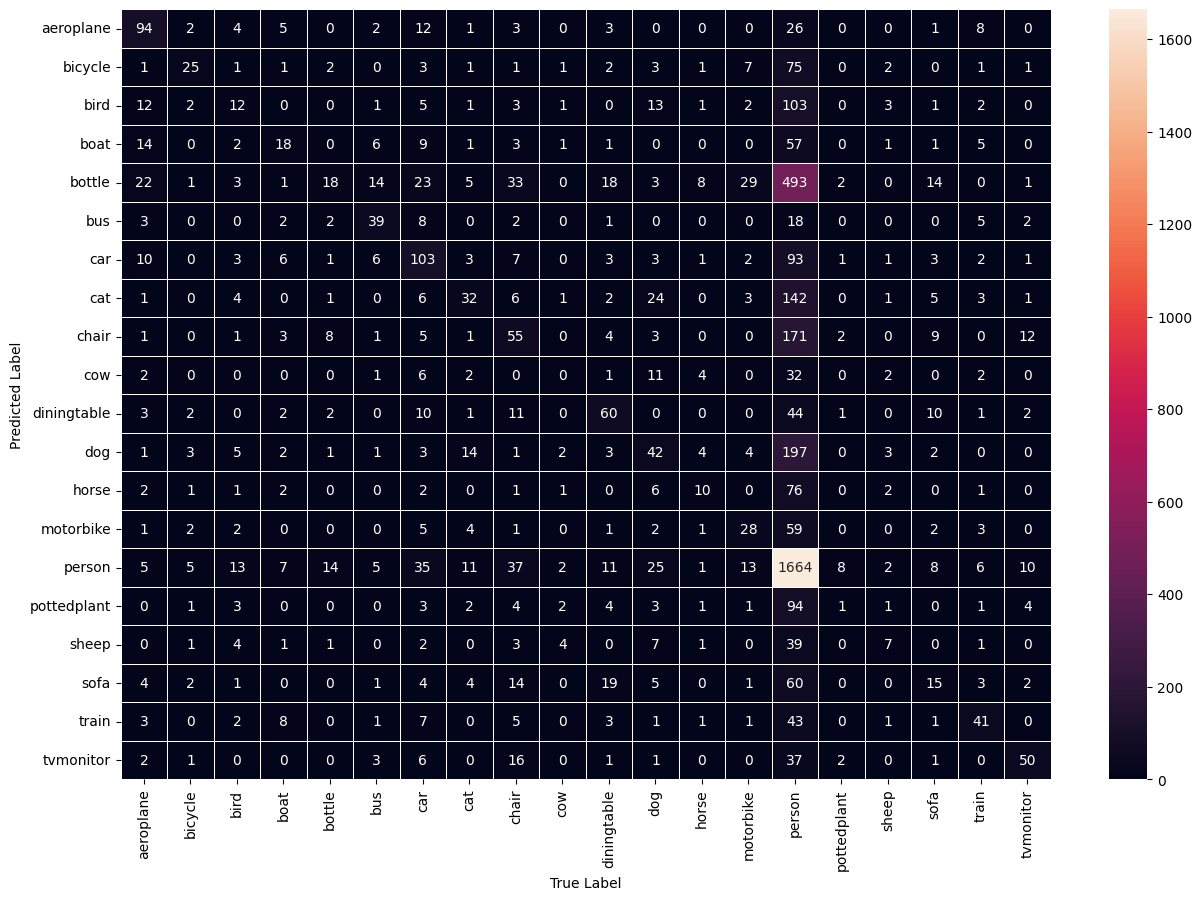

In [100]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.52      0.58      0.55       161
     bicycle       0.52      0.20      0.28       128
        bird       0.20      0.07      0.11       162
        boat       0.31      0.15      0.20       119
      bottle       0.36      0.03      0.05       688
         bus       0.48      0.48      0.48        82
         car       0.40      0.41      0.41       249
         cat       0.39      0.14      0.20       232
       chair       0.27      0.20      0.23       276
         cow       0.00      0.00      0.00        63
 diningtable       0.44      0.40      0.42       149
         dog       0.28      0.15      0.19       288
       horse       0.29      0.10      0.14       105
   motorbike       0.31      0.25      0.28       111
      person       0.47      0.88      0.62      1882
 pottedplant       0.06      0.01      0.01       125
       sheep       0.27      0.10      0.14        71
        sofa       0.21    

### SVM - HSV

In [102]:
x_train = pd.DataFrame(hsv_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(hsv_train_df['label']).to_numpy().ravel()

In [103]:
x_test = pd.DataFrame(hsv_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(hsv_test_df['label']).to_numpy().ravel()

In [104]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [105]:
pipe.score(x_test, y_test)

0.3191489361702128

In [106]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

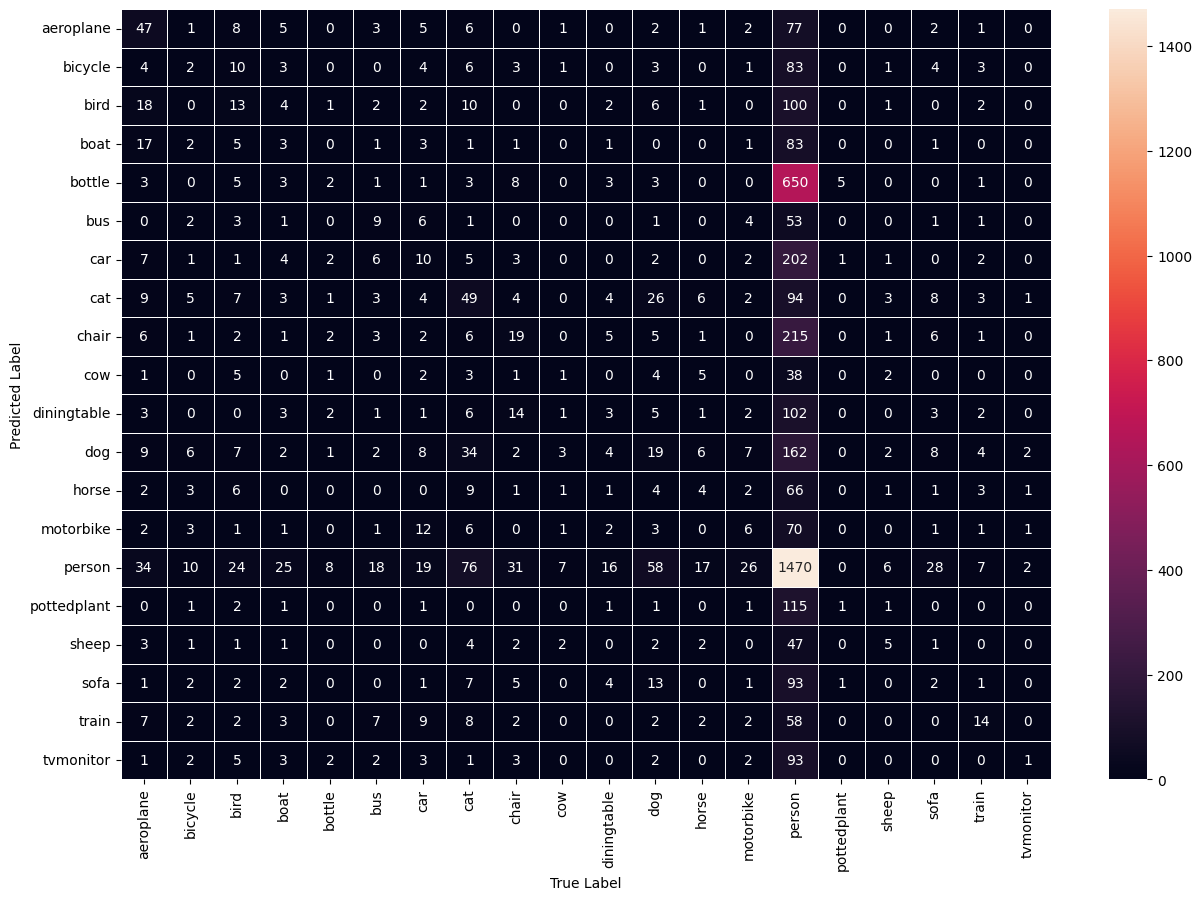

In [107]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.27      0.29      0.28       161
     bicycle       0.05      0.02      0.02       128
        bird       0.12      0.08      0.10       162
        boat       0.04      0.03      0.03       119
      bottle       0.09      0.00      0.01       688
         bus       0.15      0.11      0.13        82
         car       0.11      0.04      0.06       249
         cat       0.20      0.21      0.21       232
       chair       0.19      0.07      0.10       276
         cow       0.06      0.02      0.02        63
 diningtable       0.07      0.02      0.03       149
         dog       0.12      0.07      0.08       288
       horse       0.09      0.04      0.05       105
   motorbike       0.10      0.05      0.07       111
      person       0.38      0.78      0.51      1882
 pottedplant       0.12      0.01      0.02       125
       sheep       0.21      0.07      0.11        71
        sofa       0.03    

### SVM - SIFT

In [33]:
# the test dataset has less SIFT features than the train dataset, so drop train features to match
sift_train_subset_df = sift_train_df.iloc[:,:sift_test_df.shape[1] - 1]

In [36]:
sift_train_df.tail()

sift_1  sift_2  sift_3  sift_4  sift_5  sift_6  sift_7  sift_8  sift_9  \
16611    36.0    17.0     2.0    40.0   130.0     0.0     0.0     0.0   130.0   
16612    74.0     1.0     0.0     0.0     0.0     1.0     2.0    22.0    85.0   
16613     1.0     1.0     1.0    59.0    91.0     0.0     0.0     0.0    14.0   
16614     0.0     0.0    13.0    36.0     3.0    12.0    45.0     1.0   109.0   
16615    94.0    17.0     0.0     0.0     1.0     9.0     6.0     5.0   188.0   

       sift_10  ...  sift_3064  sift_3065  sift_3066  sift_3067  sift_3068  \
16611     65.0  ...        0.0        0.0        0.0        0.0        0.0   
16612      5.0  ...        0.0        0.0        0.0        0.0        0.0   
16613      3.0  ...        0.0        0.0        0.0        0.0        0.0   
16614      4.0  ...        0.0        0.0        0.0        0.0        0.0   
16615     60.0  ...        0.0        0.0        0.0        0.0        0.0   

       sift_3069  sift_3070  sift_3071  sift_3072   label  
16611        0.0        0.0        0.0        0.0  person  
16612        0.0        0.0        0.0        0.0  person  
16613        0.0        0.0        0.0        0.0  person  
16614        0.0        0.0        0.0        0.0  person  
16615        0.0        0.0        0.0        0.0    bird  

[5 rows x 3073 columns]

In [35]:
sift_train_subset_df.tail()

sift_1  sift_2  sift_3  sift_4  sift_5  sift_6  sift_7  sift_8  sift_9  \
16611    36.0    17.0     2.0    40.0   130.0     0.0     0.0     0.0   130.0   
16612    74.0     1.0     0.0     0.0     0.0     1.0     2.0    22.0    85.0   
16613     1.0     1.0     1.0    59.0    91.0     0.0     0.0     0.0    14.0   
16614     0.0     0.0    13.0    36.0     3.0    12.0    45.0     1.0   109.0   
16615    94.0    17.0     0.0     0.0     1.0     9.0     6.0     5.0   188.0   

       sift_10  ...  sift_2937  sift_2938  sift_2939  sift_2940  sift_2941  \
16611     65.0  ...        0.0        0.0        0.0        0.0        0.0   
16612      5.0  ...        0.0        0.0        0.0        0.0        0.0   
16613      3.0  ...        0.0        0.0        0.0        0.0        0.0   
16614      4.0  ...        0.0        0.0        0.0        0.0        0.0   
16615     60.0  ...        0.0        0.0        0.0        0.0        0.0   

       sift_2942  sift_2943  sift_2944  sift_2945  sift_2946  
16611        0.0        0.0        0.0        0.0        0.0  
16612        0.0        0.0        0.0        0.0        0.0  
16613        0.0        0.0        0.0        0.0        0.0  
16614        0.0        0.0        0.0        0.0        0.0  
16615        0.0        0.0        0.0        0.0        0.0  

[5 rows x 2946 columns]

In [37]:
sift_labels = sift_train_df['label'].tolist()
sift_labels_series = pd.Series(sift_labels)

In [38]:
# merge
sift_train_df = sift_train_subset_df.merge(sift_labels_series.rename('label'), left_index=True, right_index=True)

In [39]:
sift_train_df.head()

sift_1  sift_2  sift_3  sift_4  sift_5  sift_6  sift_7  sift_8  sift_9  \
0     8.0     2.0     2.0     2.0     3.0    15.0   106.0    96.0    12.0   
1     4.0     0.0     1.0    11.0    50.0    71.0    41.0    14.0    38.0   
2     1.0     0.0     2.0     1.0     2.0     1.0     1.0     7.0     1.0   
3    54.0    23.0    22.0    19.0    11.0    13.0     1.0     5.0    51.0   
4     1.0    26.0   125.0    20.0     3.0     3.0     1.0     0.0   165.0   

   sift_10  ...  sift_2938  sift_2939  sift_2940  sift_2941  sift_2942  \
0     18.0  ...        0.0        0.0        0.0        0.0        0.0   
1      8.0  ...        0.0        0.0        0.0        0.0        0.0   
2      0.0  ...        0.0        0.0        0.0        0.0        0.0   
3      8.0  ...        0.0        0.0        0.0        0.0        0.0   
4     84.0  ...        0.0        0.0        0.0        0.0        0.0   

   sift_2943  sift_2944  sift_2945  sift_2946      label  
0        0.0        0.0        0.0        0.0     person  
1        0.0        0.0        0.0        0.0  aeroplane  
2        0.0        0.0        0.0        0.0     person  
3        0.0        0.0        0.0        0.0     person  
4        0.0        0.0        0.0        0.0     person  

[5 rows x 2947 columns]

In [40]:
sift_test_df.head()

sift_1  sift_2  sift_3  sift_4  sift_5  sift_6  sift_7  sift_8  sift_9  \
0     1.0     2.0     6.0     9.0    16.0    28.0     3.0     1.0   117.0   
1     0.0     0.0    14.0     9.0     3.0     0.0     0.0     0.0    17.0   
2    25.0    34.0     0.0     9.0    35.0    16.0     2.0     9.0    69.0   
3    58.0     5.0     0.0     0.0     0.0     0.0     0.0     5.0   145.0   
4     1.0     2.0     7.0    90.0    72.0    42.0    44.0     5.0    57.0   

   sift_10  ...  sift_2936  sift_2937  sift_2938  sift_2939  sift_2940  \
0     22.0  ...        0.0        0.0        0.0        0.0        0.0   
1      1.0  ...        0.0        0.0        0.0        0.0        0.0   
2      2.0  ...        0.0        0.0        0.0        0.0        0.0   
3     62.0  ...        0.0        0.0        0.0        0.0        0.0   
4     51.0  ...        0.0        0.0        0.0        0.0        0.0   

   sift_2941  sift_2942  sift_2943  sift_2944   label  
0        0.0        0.0        0.0        0.0  person  
1        0.0        0.0        0.0        0.0  person  
2        0.0        0.0        0.0        0.0   horse  
3        0.0        0.0        0.0        0.0    sofa  
4        0.0        0.0        0.0        0.0  person  

[5 rows x 2945 columns]

In [41]:
# drop two columns from sift_train_df to match number of features with test set
sift_train_df = sift_train_df.drop(sift_train_df.columns[[-2, -3]], axis=1)

In [46]:
x_train = pd.DataFrame(sift_train_df.drop(['label'],axis=1)).to_numpy()
y_train = pd.DataFrame(sift_train_df['label']).to_numpy().ravel()

In [47]:
x_test = pd.DataFrame(sift_test_df.drop(['label'],axis=1)).to_numpy()
y_test = pd.DataFrame(sift_test_df['label']).to_numpy().ravel()

In [48]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('rbfsvc', SVC(kernel='rbf', C=100, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rbfsvc', SVC(C=100, cache_size=10000))])

In [49]:
pipe.score(x_test, y_test)

0.396798652064027

In [50]:
y_pred = pipe.predict(x_test)

[Text(0.5, 80.7222222222222, 'True Label'),
 Text(158.22222222222223, 0.5, 'Predicted Label')]

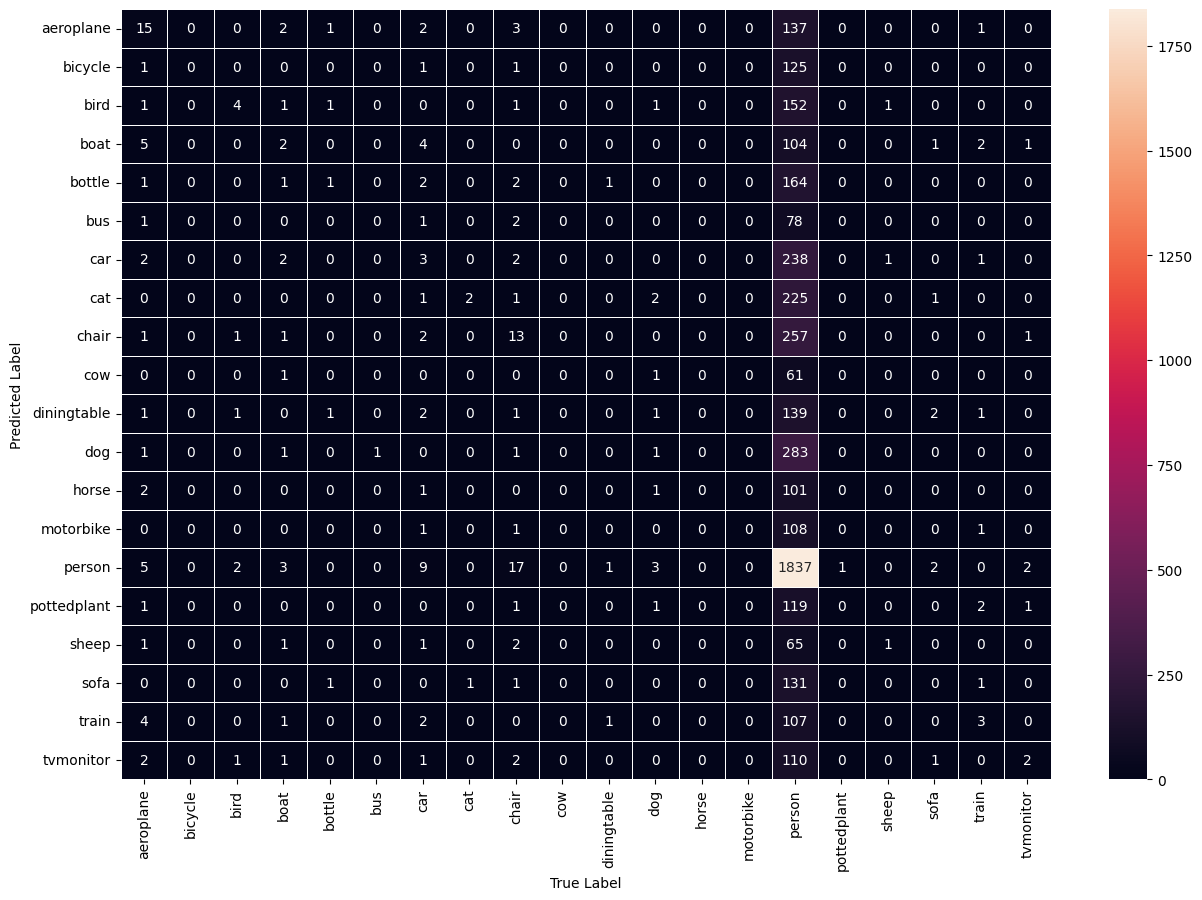

In [51]:
y_test_labels = sorted(pd.unique(pd.Series(y_test)))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, linewidths=.5, fmt='d', xticklabels=y_test_labels, yticklabels=y_test_labels, ax=ax)
ax.set(xlabel='True Label', ylabel='Predicted Label')

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   aeroplane       0.34      0.09      0.15       161
     bicycle       0.00      0.00      0.00       128
        bird       0.44      0.02      0.05       162
        boat       0.12      0.02      0.03       119
      bottle       0.20      0.01      0.01       172
         bus       0.00      0.00      0.00        82
         car       0.09      0.01      0.02       249
         cat       0.67      0.01      0.02       232
       chair       0.25      0.05      0.08       276
         cow       0.00      0.00      0.00        63
 diningtable       0.00      0.00      0.00       149
         dog       0.09      0.00      0.01       288
       horse       0.00      0.00      0.00       105
   motorbike       0.00      0.00      0.00       111
      person       0.40      0.98      0.57      1882
 pottedplant       0.00      0.00      0.00       125
       sheep       0.33      0.01      0.03        71
        sofa       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
